# 0.0 IMPORTS

In [ ]:
# # pip install jupyterthemes
# from jupyterthemes import get_themes
# import jupyterthemes as jt
# from jupyterthemes.stylefx import set_nb_theme

In [ ]:
# set_nb_theme('chesterish')

In [ ]:
# installing libs in colab
!pip install inflection

# !pip install boruta
# from boruta import  BorutaPy

In [ ]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime


from IPython.core.display     import HTML
from IPython.display          import Image
from scipy                    import stats


from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics          import mean_absolute_error, mean_squared_error
from sklearn.linear_model     import LinearRegression, Lasso
from sklearn.ensemble         import RandomForestRegressor
import xgboost                as xgb
import pickle


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 0.1. Help Function

In [ ]:
## 0.2 Loadind Data

url_store = 'https://rossmandatabase.s3-sa-east-1.amazonaws.com/store.csv'
url_train = 'https://rossmandatabase.s3-sa-east-1.amazonaws.com/train.csv'
df_store_raw = pd.read_csv(url_store, low_memory = False)
df_sales_raw = pd.read_csv(url_train, low_memory = False)

#merge dos dados
df_raw = pd.merge(df_sales_raw,df_store_raw, how = 'left', on = 'Store' )

# adjust jupyter notebook viz
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()



# valor de chi2 e o valor na primeira posciao na matriz de chi2
# fucao de calculod de v de cramer
def crammer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    # n = soma de linhas
    n = cm.sum()
    # r, k nr de linhas e colunas respectivamente
    r,k = cm.shape
    
    # correcao das equacoes para evitar bias
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 -(k-1)*(r-1)/(n-1))
    
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1))  )


################################################################################
# MAPE
#y valor real, yhat valores de previsao
def mean_absolute_percentage_error( y, yhat):
  return np.mean( np.abs ( ( y-yhat ) / y ) )


def mean_percentage_error( y, yhat):
  return np.mean(  ( y-yhat ) / y  )



def ml_error( model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error( y, yhat))

  return pd.DataFrame( {"Model Name": model_name,
                        "MAE": mae,
                        "MAPE": mape,
                        'RMSE': rmse
                        
                        }, index = [0]) # reset index, pra n dar erro

  
# Fatiando a amostra da serie para Cross Validation
# # obtendo o ultimo dia( ['date'].max() ) menos 6 semanas
# validation_start_data primeira data da nossa validacao
# verbose por default nao imprimira todas as interacoes
def cross_validation( x_training, kfold, model_name, model, verbose = False):
  

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed( range( 1, kfold + 1 ) ): 
    if verbose:

      print( '\nkFold Number : {}' .format( k ))
    validation_start_data = x_training['date'].max() - datetime.timedelta( days = k*6*7) # *1 nao muda nada, 2, sao duas semanas, etc...


    validation_end_data = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7) # 0, para pegar  o primeiro

    # filtrando dataset
    training = x_training[ x_training['date'] < validation_end_data]

    validation = x_training[ (x_training['date'] >= validation_end_data) & (x_training['date'] <= validation_end_data)]


    # training and validation dataset

    xtraining = training.drop( ['date', 'sales'], axis = 1)
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis = 1)
    yvalidation = validation['sales']

    #model
    m = model.fit( xtraining, ytraining)

    #prediction
    yhat = m.predict( xvalidation)

    #performance
    m_result = ml_error( model_name, np.expm1(yvalidation),np.expm1(yhat)  )

    #guardando performace para cada kFold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

    # criando um dataframe com as medias

  return pd.DataFrame( { 'Model Name' : model_name,
                         'MAE Cross V'  : np.round( np.mean(mae_list ),2 ).astype(str) + ' +/- ' + np.round( np.std( mae_list ),2 ).astype(str),
                         'MAPE Cross V' : np.round( np.mean(mape_list ),2 ).astype(str) + ' +/- ' + np.round( np.std( mape_list ),2 ).astype(str),
                         'RMSE Cross V' : np.round( np.mean(rmse_list ),2 ).astype(str) + ' +/- ' + np.round( np.std( rmse_list ),2 ).astype(str) }, index=[0] )
                        



Populating the interactive namespace from numpy and matplotlib


In [ ]:
# df_raw.sample()

# 1.0 DESCRICAO DE DADOS


In [ ]:
# Copiando os dados da sessao
df1 = df_raw.copy()

## 1.1 Rename Columns

In [ ]:
# rename columns with snakecase
cols_old = ['Store',
        'DayOfWeek',
        'Date',
        'Sales',
        'Customers',
        'Open', 
        'Promo',
        'StateHoliday', 
        'SchoolHoliday',
        'StoreType',
        'Assortment',
        'CompetitionDistance',
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2 Data Dimensional

In [ ]:
print('Numbers of Rows {}'. format(df1.shape[0]))
print('Numbers of Columns {}'. format(df1.shape[1]))

# Resume
df1.shape

Numbers of Rows 1017209
Numbers of Columns 18


(1017209, 18)

## 1.3 Data types

In [ ]:
# Visualize datetypes
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [ ]:
# Convert date to datetime type
# df1.date = pd.to_datetime(df1.date)

# normal conversion
# df1["date"] = df1["date"].astype("datetime64[ns]")
# astype('datetime64[ns]') 

# colab acept
df1['date'] = pd.to_datetime(df1['date'],  errors='coerce')


In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.3 Check NA

In [ ]:
# Visualize NAs values
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [ ]:
df1['competition_distance'].max()

75860.0

In [ ]:
# # competition_distance max value 75860.0 - Distancia em metros do concorente.
# colocando uma distancia bem maior que o valor maximo nos Nas, que representa que o concorente mais proximo
# esta muito distante, como se n existisse, e nao removemos os valores, se nao houver Na, retorna
# o valor que la esta contido.

df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x) 
# 
# # competition_open_since_month  - mes e ano aproximado da abertura do concorente mais proximo
# Nos valores NAs da  competition_open_since_month, receber a data, portnto o mes na coluna mes e ano na coluna ano, suponhando que
# em caso de NA, podemos considerar a data da venda daquele establecimento como o tempo da existencia da competicao,
# para nao haver o problema de haver distancia de loja, logo exste loja, mas  n ter a data deexistencia dela, pois se for igual a 0, significa
# que existe uma loja, mas que nao abriu ainda, por ser 0

df1['competition_open_since_month'] = df1.apply( lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# A mesma logica deve ser aplicada a competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week - A promoção2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando
df1['promo2_since_week'] = df1.apply( lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year - ###
df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval
# descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente.
# Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio,
# agosto e novembro de qualquer ano para essa loja


In [ ]:
# # promo_interval dictionary
# dicionario que preenche nome de mes
month_map  = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sept",  10: "Oct",  11: "Nov",  12: "Dec"}

# Fill NA = 0.
df1['promo_interval'].fillna(0, inplace = True)
# Map dictionary in column 
# extrai o mes da data e apply um map
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [ ]:
# Se o month_map estiver dentro do intervalo de promocao, logo a loja esta em promocao, criar coluna is_promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [ ]:
# df1['month_map']

In [ ]:
df1.sample(10).T

,526464,311923,1010738,699987,638257,911863,513028,420758,252573,245642
store,970,889,219,553,148,579,914,74,359,1013
day_of_week,1,7,7,6,5,5,6,4,7,1
date,2014-03-17 00:00:00,2014-10-12 00:00:00,2013-01-06 00:00:00,2013-10-12 00:00:00,2013-12-06 00:00:00,2013-04-05 00:00:00,2014-03-29 00:00:00,2014-06-19 00:00:00,2014-12-14 00:00:00,2014-12-22 00:00:00
sales,4751,0,0,9109,6749,7497,6844,0,0,6229
customers,527,0,0,917,700,871,791,0,0,646
open,1,0,0,1,1,1,1,0,0,1
promo,1,0,0,0,1,0,0,1,0,0
state_holiday,0,0,0,0,0,0,0,a,0,0
school_holiday,0,0,0,0,0,1,0,0,0,1
store_type,a,d,a,c,a,c,c,a,d,a


In [ ]:
# All Nas transformed
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types of variables

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )     
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )    

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

# resolved data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [ ]:
# Separing numerical vars and categorical vars

num_atributes = df1.select_dtypes(include = ['int64', 'float64', 'int32'])
cat_atributes = df1.select_dtypes(exclude = ['int64', 'int32','float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [ ]:
# Central tendency - mean, median

# aplicar operacao em todas colunas
central_tendecy = pd.DataFrame(num_atributes.apply(np.mean)).T
central_tendecy2 = pd.DataFrame(num_atributes.apply(np.median)).T

# Disparsion - std, min, max, range, skew, kurtosis

dispersion_std = pd.DataFrame(num_atributes.apply(np.std)).T
dispersion_min = pd.DataFrame(num_atributes.apply(min)).T
dispersion_max = pd.DataFrame(num_atributes.apply(max)).T
dispersion_range = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T
dispersion_skew = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T
dispersion_kurtosis = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

# concatenate

metrics = pd.concat([dispersion_min,dispersion_max,dispersion_range,central_tendecy, central_tendecy2,dispersion_std, dispersion_skew,dispersion_kurtosis]).T.reset_index()
metrics.columns = ['atributes','min','max','range','mean','median','std','skew','kurtosis']

In [ ]:
metrics

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


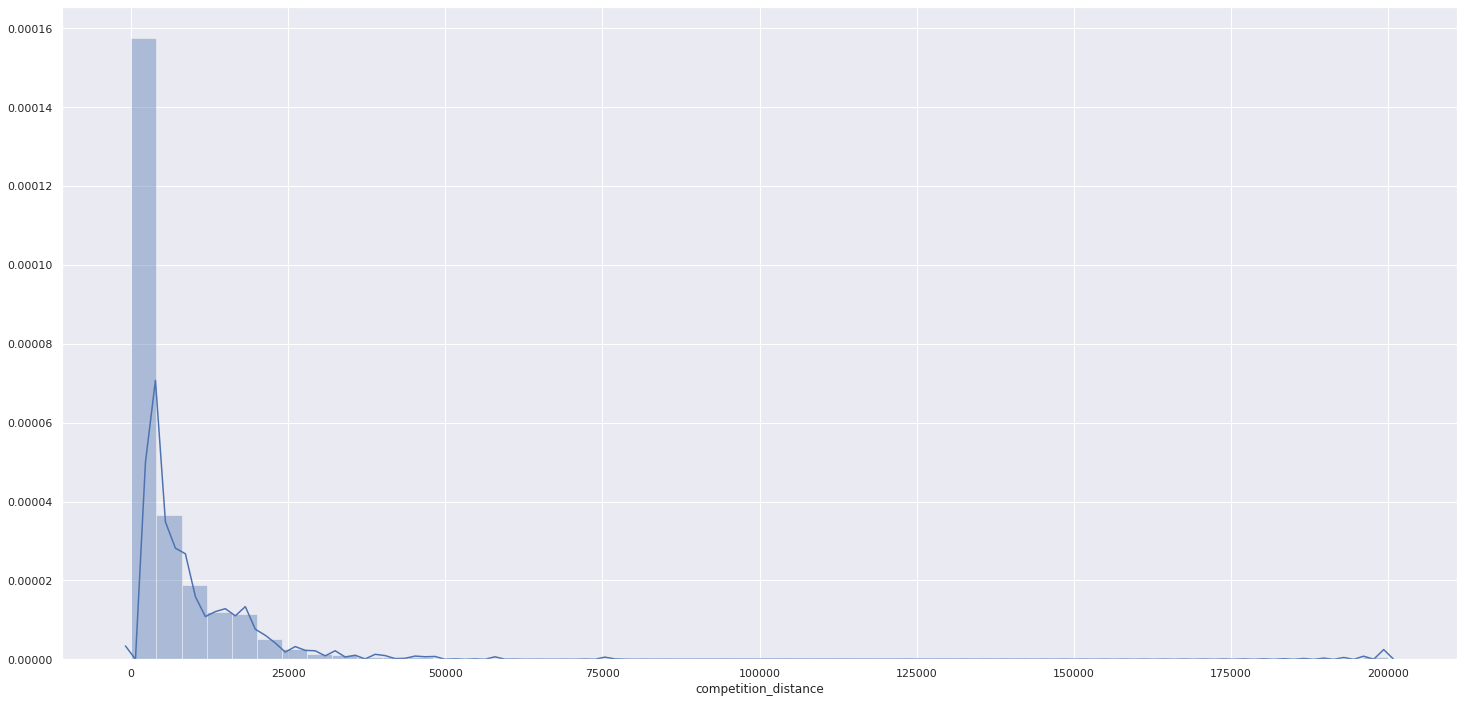

In [ ]:
sns.distplot(df1['competition_distance'])

### 1.7.2 categorical Atributes

In [ ]:
# Nivel vars, shape[0] - look unique vals
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

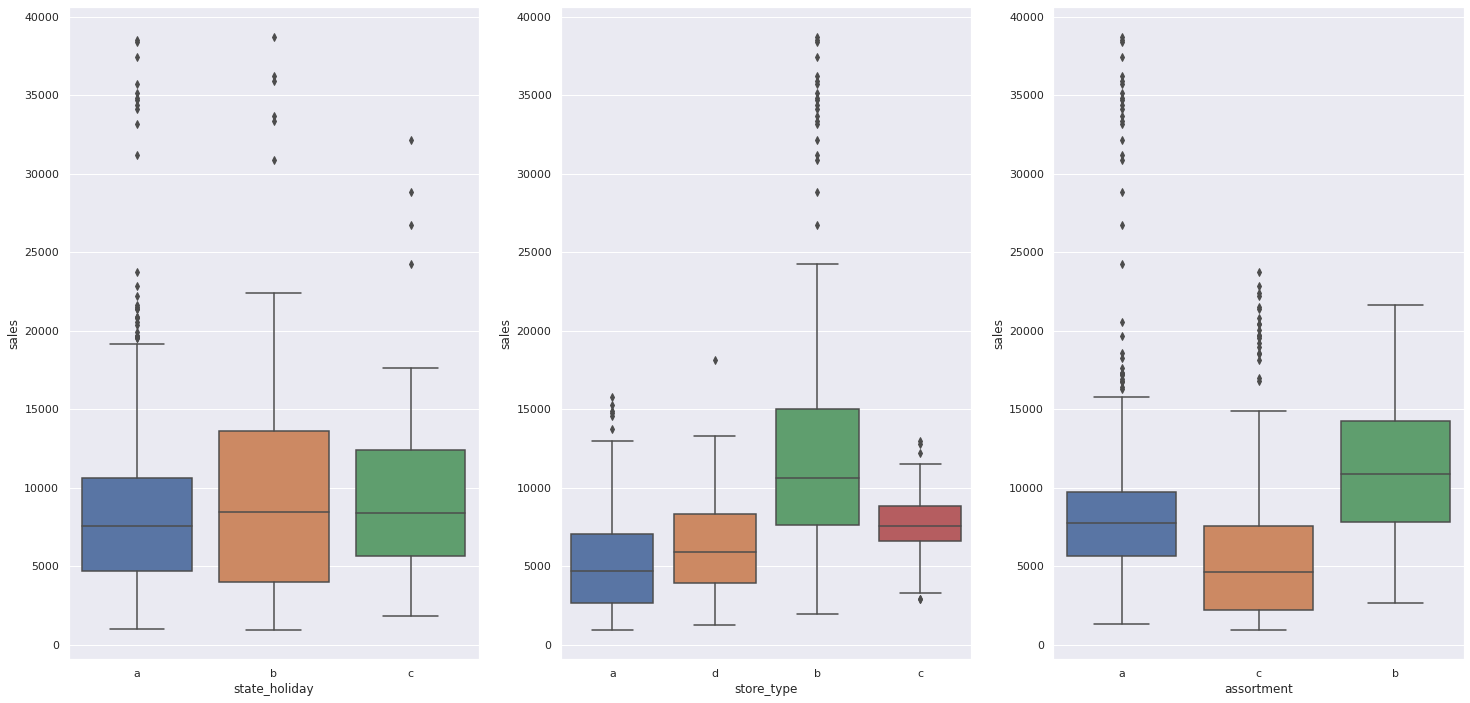

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1,3,1)
sns.boxplot( x= "state_holiday" , y= 'sales' , data =aux1)

plt.subplot( 1,3,2)
sns.boxplot( x= "store_type" , y= 'sales' , data =aux1)

plt.subplot( 1,3,3)
sns.boxplot( x= "assortment" , y= 'sales' , data =aux1);

# 2.0 FEATURE ENGINEERING

In [ ]:
# criando uma copia do arquivo
df2 = df1.copy()

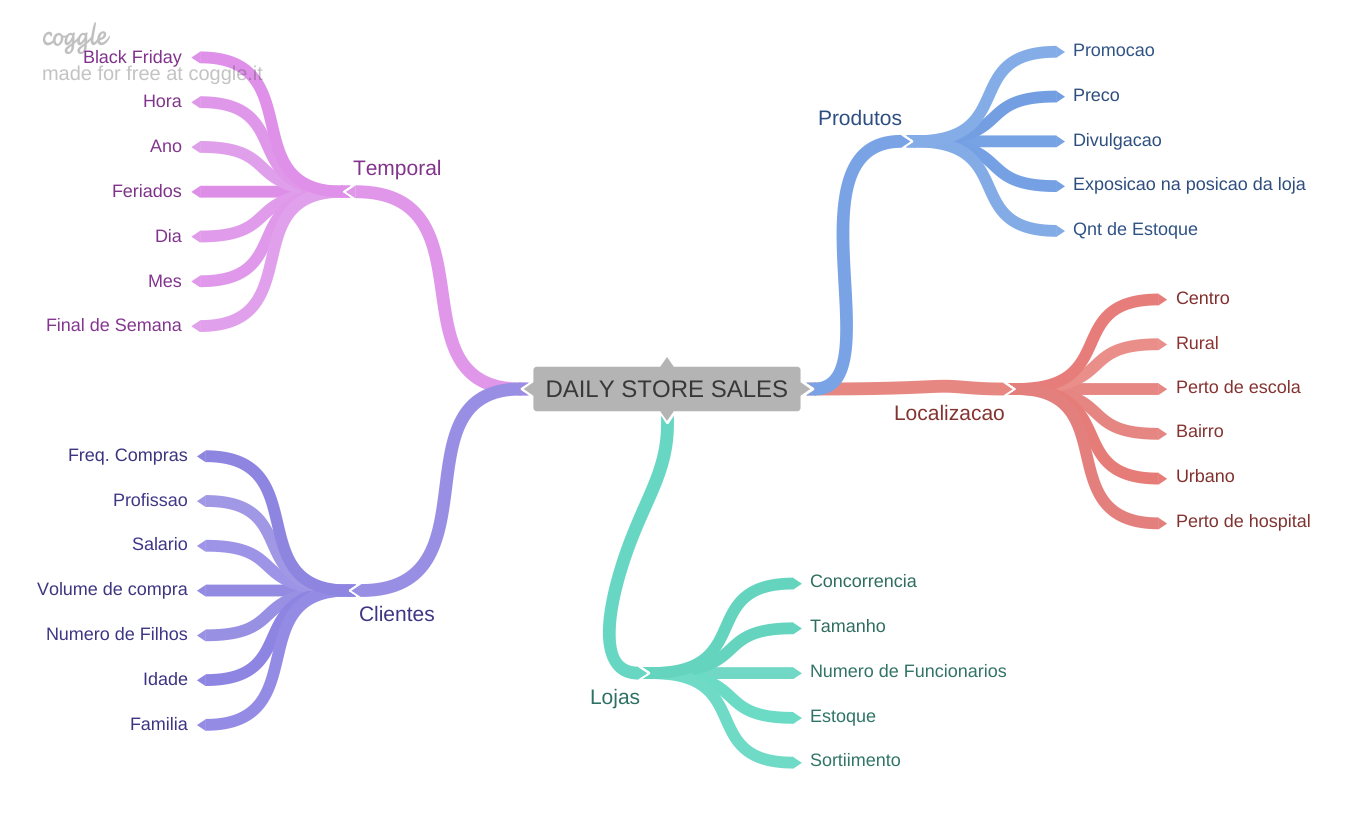

In [ ]:
Image('https://rossmandatabase.s3-sa-east-1.amazonaws.com/DAILY_STORE_SALES.png')

## 2.1 Mapa mental de hopoteses

### 2.1.1 Criancao das Lojas 



**1.** Lojas com maior numero de funionarios deveriam vender mais.


**2.** Lojas com maior estoque deveriam vender mais.


**3.** Lojas com maior porte deveriam vender mais.


**4.** Lojas com menor porte deveriam vender menos.


**5.** Lojas com maior sortimento(opcoes de produtos) deveriam vender mais.

### 2.1.2 Criancao do Produto 

**1.** Lojas com maior investimento marketing/divulgacao deveriam vender mais produtos.


**2.** Lojas que expoem mais produtos na vitrine deveriam vender mais produtos.


**3.** Lojas que tem precos menores nos produtos deveriam vender mais.


**4.** Lojas que tem precos menores por mais tempo nos produtos deveriam vender menos.


### 2.1.3 Criancao do Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem no final de semana deveriam vender mais.

## 2.2 Lista de Priorizacao de hipoteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com maior porte deveriam vender mais.

**3.** Lojas com menor porte deveriam vender menos.

**4.** Lojas com promocoes activas por mais tempo deveriam vender mais.

**5.** Lojas mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas no feriado de natal deveriam vender mais.

**8.** Lojas  deveriam vender mais ao longo do ano.

**9.** Lojas  deveriam vender mais depois do dia 10 de cada mes.

**10.** Lojas  deveriam vender menos durante os finais de semana.

**11.** Lojas  deveriam vender menos durante feriados escolares .


## 2.3. Feature engineering

In [ ]:
# create year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
# mudar a formatacao da data apenas
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# Intervalos de tempo categorizados por:
# 1. competition since

df2['competition since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day= 1), axis = 1)
df2['competition_time_month'] = (( df2['date'] - df2['competition since'])/30).apply( lambda x: x.days).astype(int)


In [ ]:
# 2. promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x :datetime.datetime.strptime( x  + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7))

df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [ ]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x:"basic" if x =="a" else "extra" if x == "b" else  "extended")

In [ ]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x== 'c' else 'regular_day')

In [ ]:
df2.sample(4).T

,899111,305377,246282,34656
store,92,888,663,92
day_of_week,2,7,7,2
date,2013-04-16 00:00:00,2014-10-19 00:00:00,2014-12-21 00:00:00,2015-06-30 00:00:00
sales,2915,0,0,9319
customers,366,0,0,685
open,1,0,0,1
promo,0,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,1
store_type,c,d,a,c


# 3.0 FILTRAGEM DE VARIAVEIS

In [ ]:
df3 = df2.copy()

# visualizar vars para descrever filtragens e selecoes de vars.
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


**Variaveis de restricao de negoio**

**1.** customers - e uma variavel de restricao de negocio, ou seja nao teremos essa var no inicio .

**2.** open - deve ser diferente de 0, porque 0 a loja esta fechada e nao serve, senao aberta .

**3.** sales - deve ser diferente maior que 0, porque 0 a loja esta fechada, ou seja open tambe e 0, entao so preciso filtrar por onde 'e maior de 0, pois significa que a loja esta aberta.


## 3.1 Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.1 Selecao das Colunas

In [ ]:
drop_cols = ["customers", "open","promo_interval","month_map"]
# axis = 0 - linhas, =1 colunas 
df3 = df3.drop(drop_cols, axis = 1)

# 4.0 ANALISE EXPLORATORIA DE DADOS

In [ ]:
df4 = df3.copy()

In [ ]:
df4.sample(2).T

,218812,477621
store,273,72
day_of_week,5,2
date,2015-01-16 00:00:00,2014-04-29 00:00:00
sales,7896,6236
promo,1,1
state_holiday,regular_day,regular_day
school_holiday,0,0
store_type,a,a
assortment,extended,basic
competition_distance,8480,2200


## 4.1 Analise Univariada

### 4.1.1 response variable

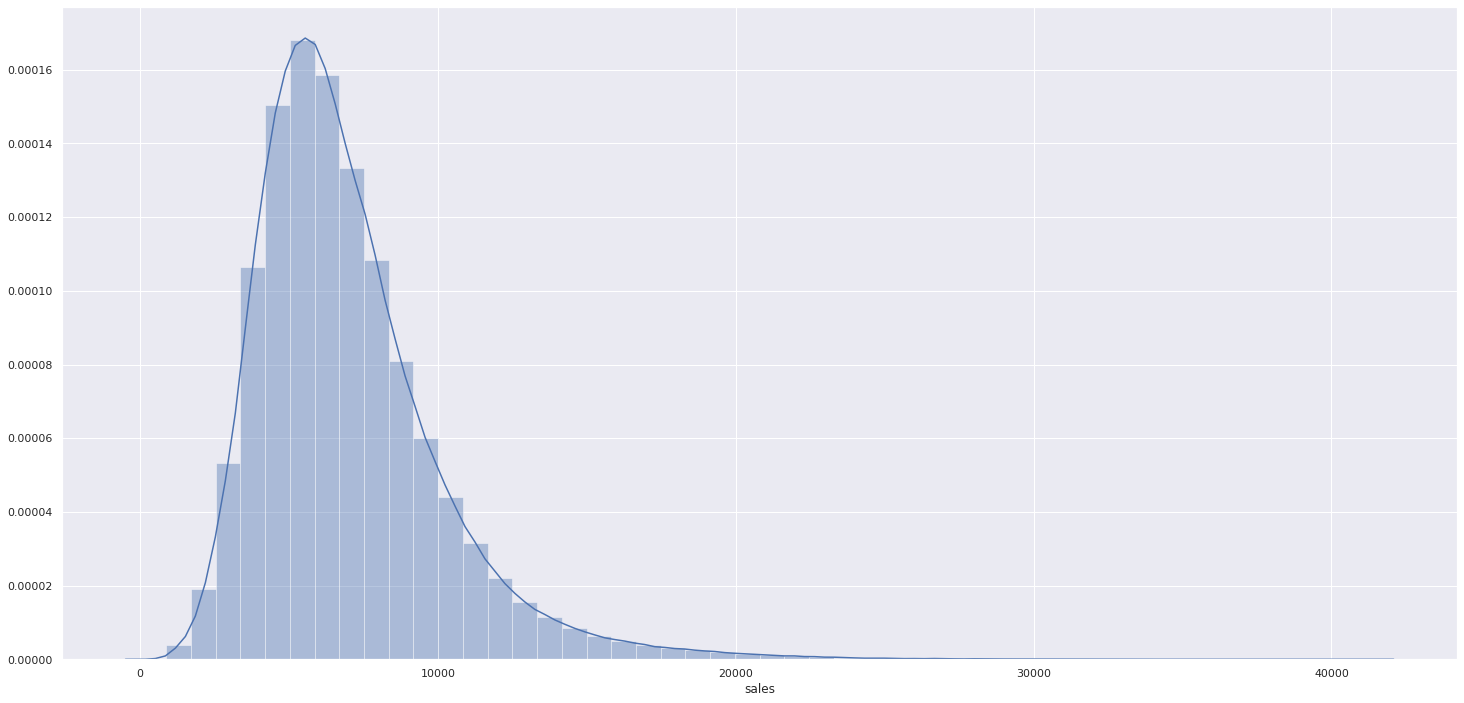

In [ ]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical variable

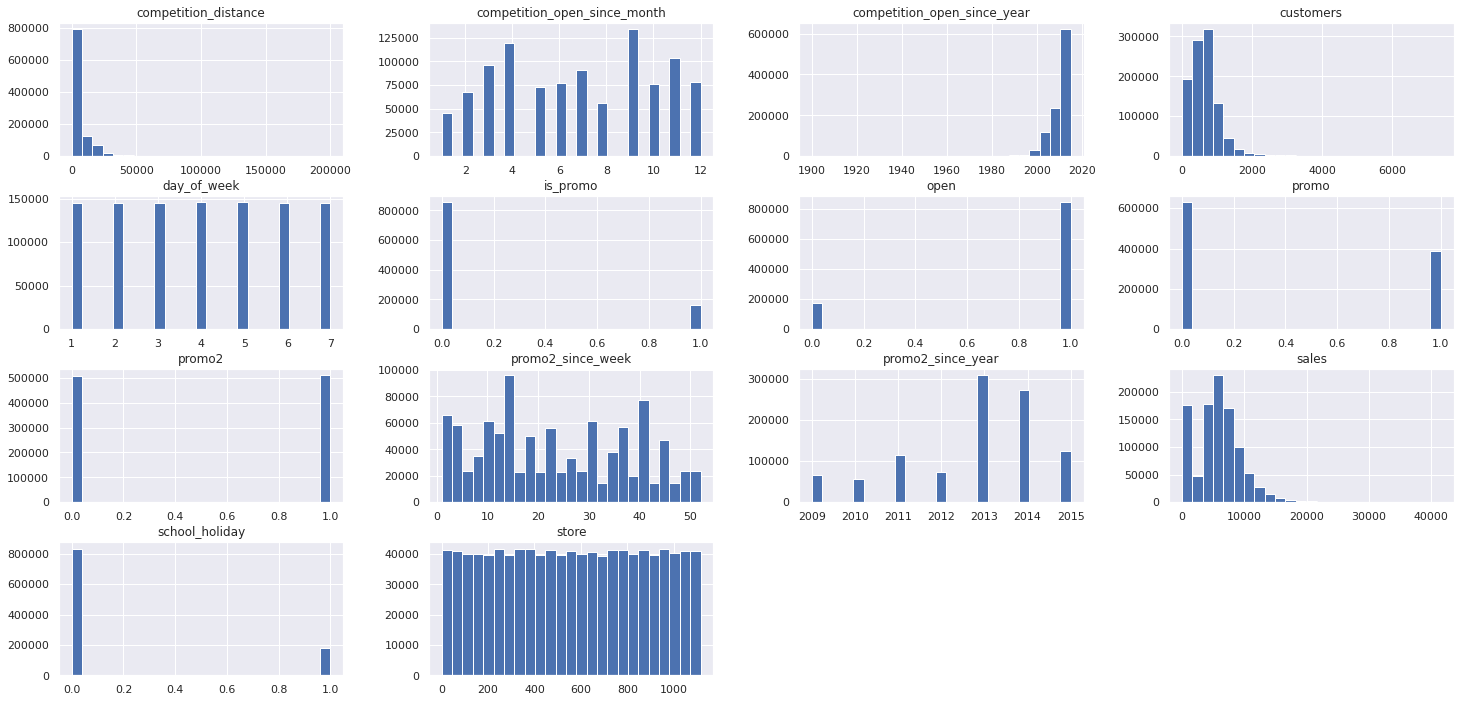

In [ ]:
num_atributes.hist(bins = 25);

### 4.1.1 Categorial variable

In [ ]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

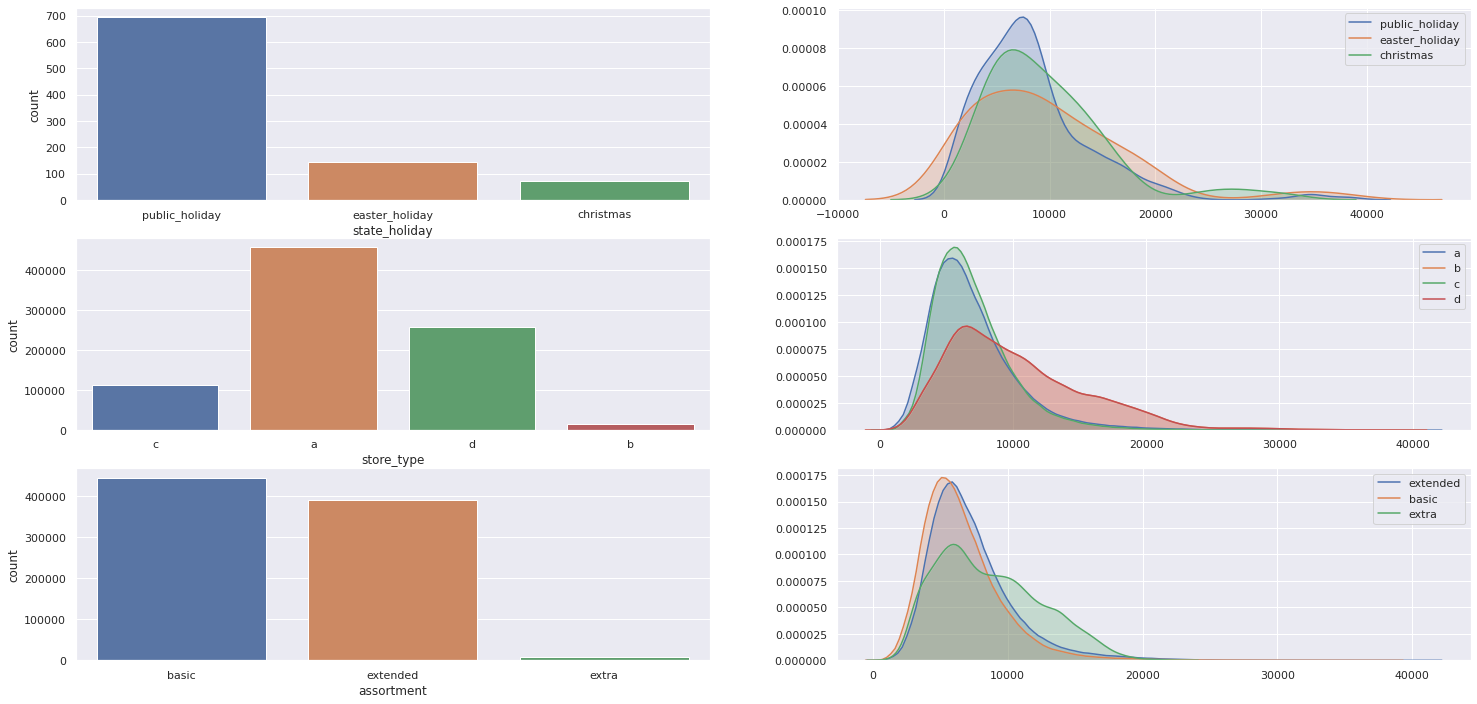

In [ ]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

# story_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'd', shade = True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);


## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**Falsa.** Constatamos que lojas com maior assortment na verdade tem volume de vendas muito inferiroas outras. Logo:

**Lojas com maior assortment vendem muito pouco.**

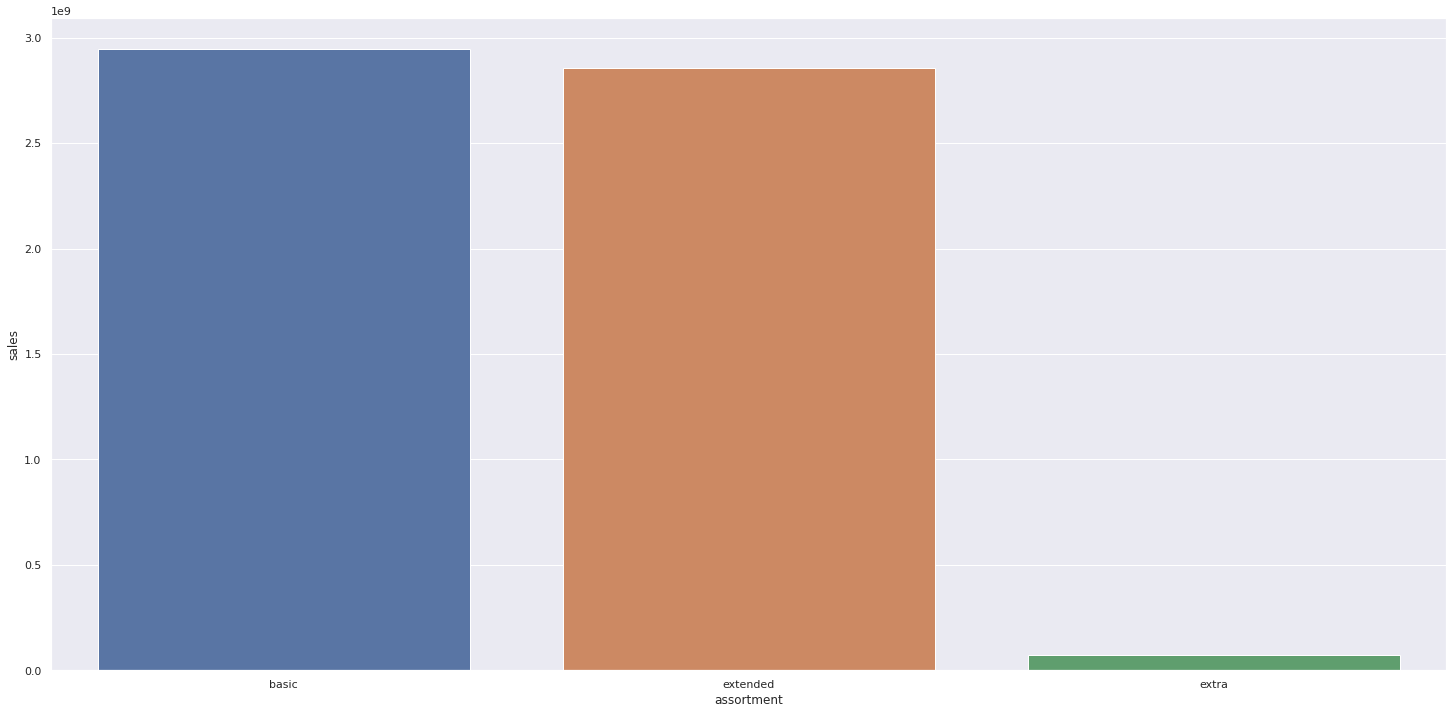

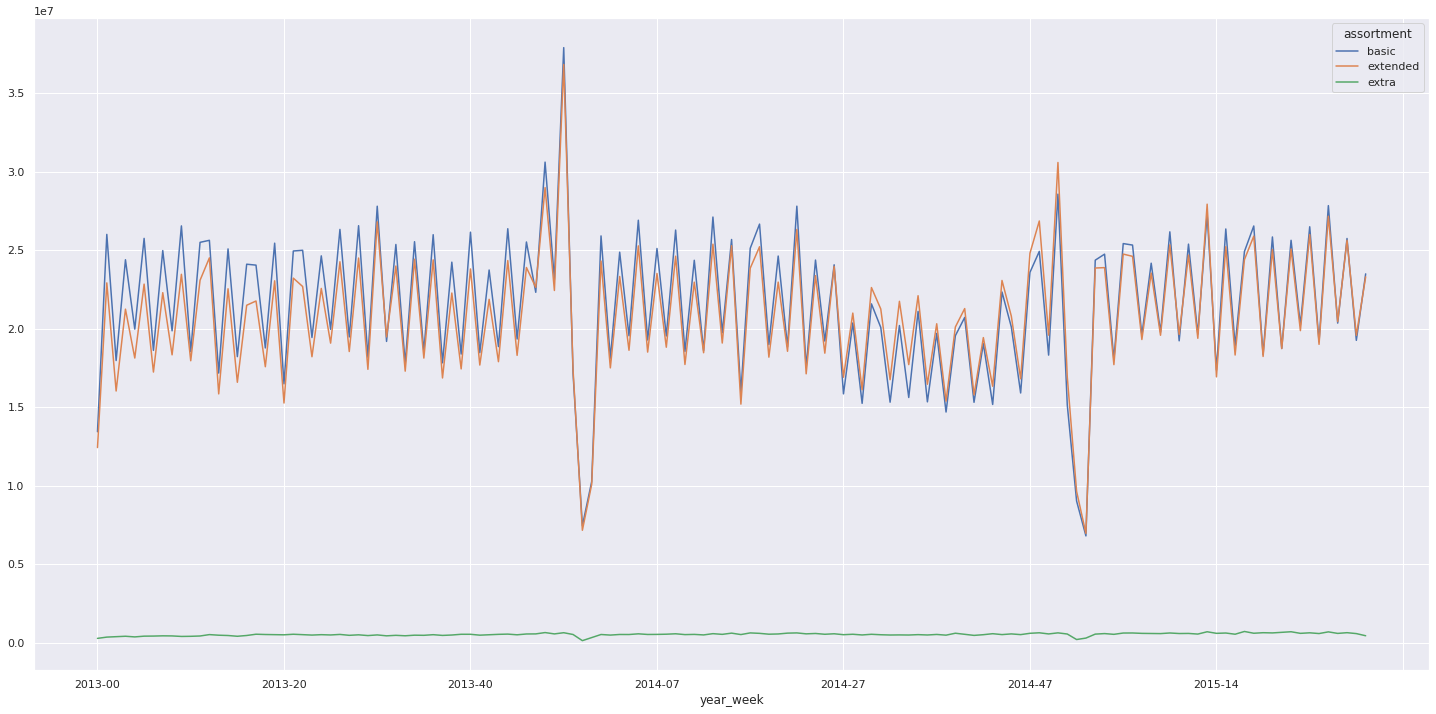

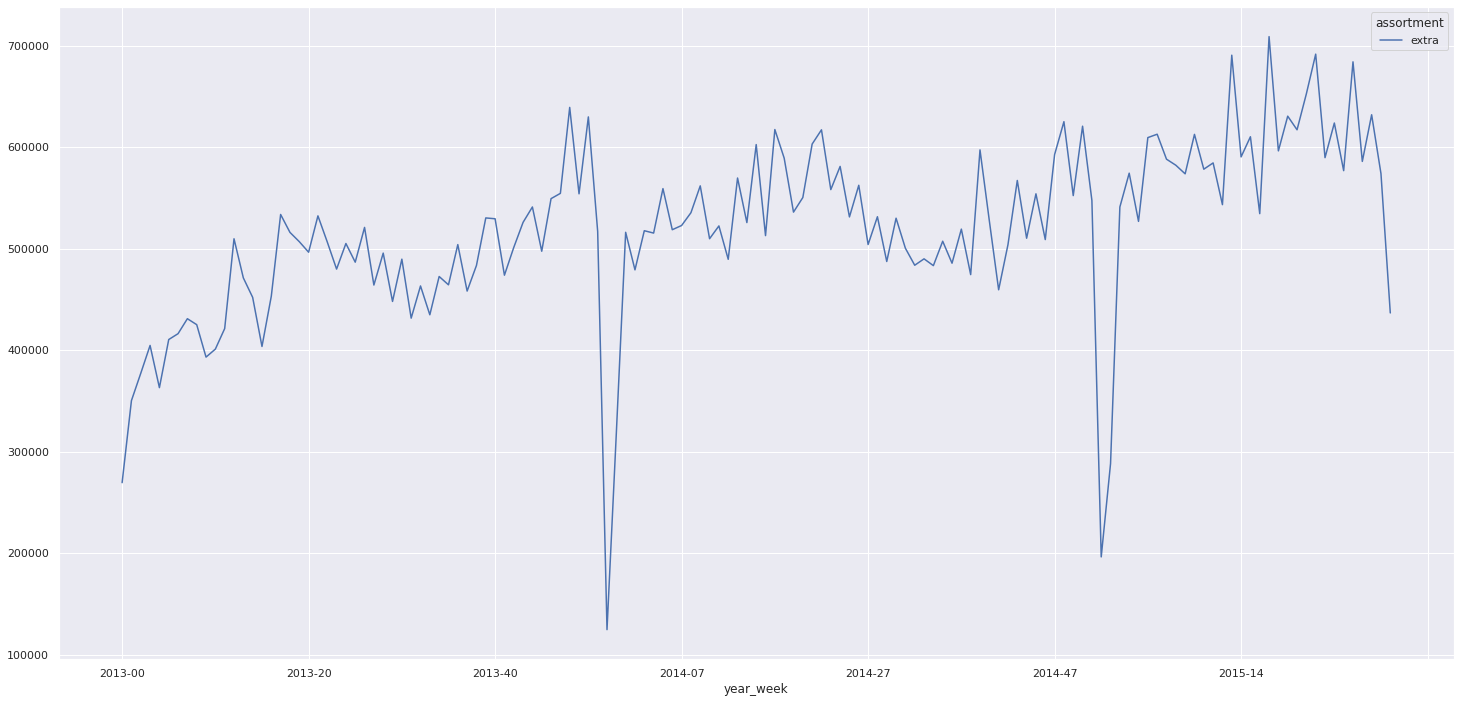

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y ='sales', data = aux1);

# plotando vendas de assortment ao longo do ano (semanas do ano)
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

#plotando um plot para ver variacao de vendas ao lango do tempo
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()


### **H2.** Lojas com competidores mais proximos, deveriam vender menos.

**Falsa** Constatamos que lojas com competidores mais proximos, vendem mais, e quanto maior for a distancia 
a concorrencia a loja vende menos

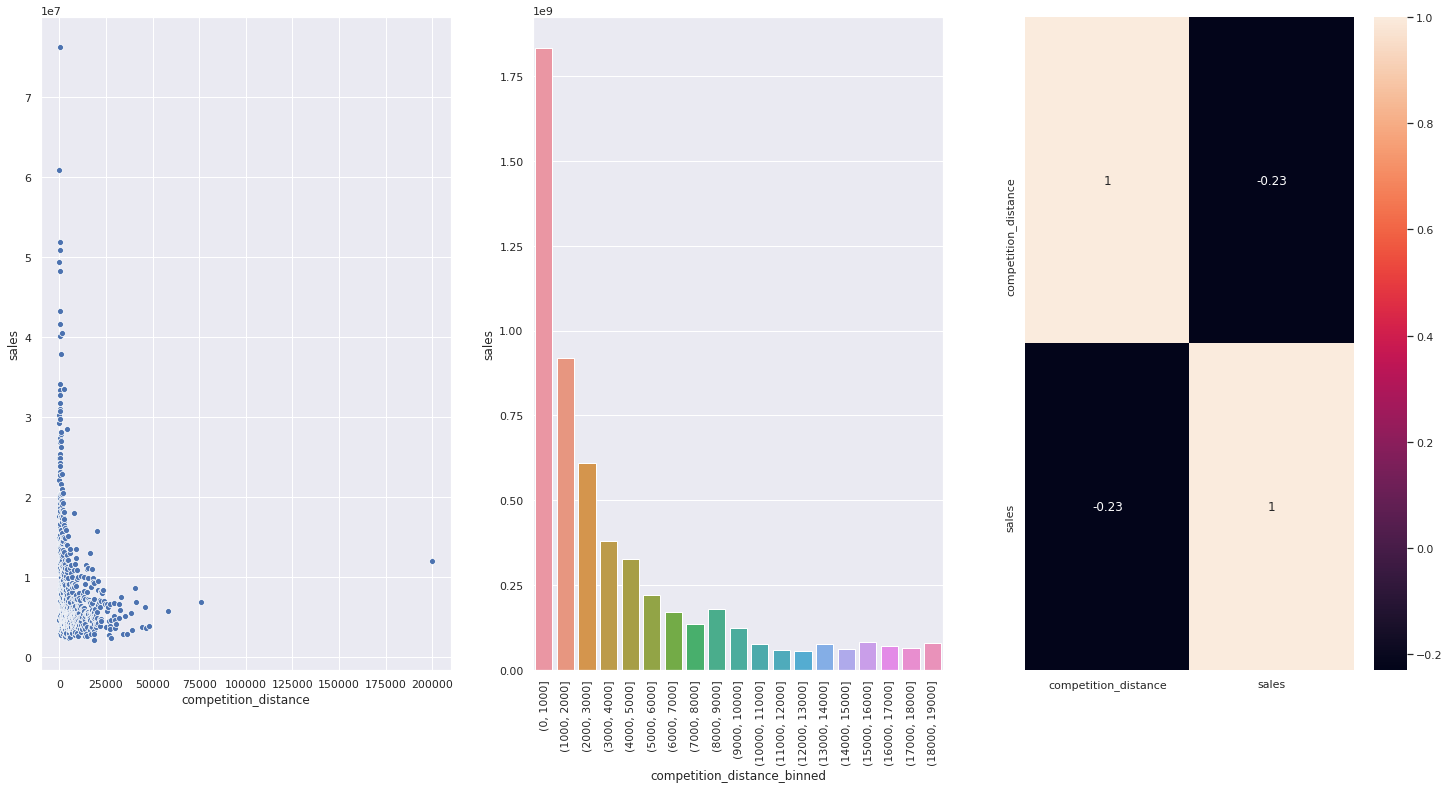

In [ ]:


aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# subplot(linhas, colunas. posicao)
subplot (1,3,1)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux4);
# agrupamento dos bins em intervalo de 1000 a 1000, ate 20000
subplot (1,3,2)
bins = list(np.arange(0,20000,1000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins = bins)
aux5 = aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux5)
# rotate text in barplot 90
plt.xticks( rotation = 90)

subplot (1,3,3)
# correlation ( method = tipode corr, annot = visualizar nr da correlacao)
sns.heatmap( aux4.corr(method= 'pearson'), annot = True);

### **H3.** Lojas com competidores a mais tempo , deveriam vender mais.

**Falsa** Constatamos o contrario, lojas com competidores a mais tempo acabam vendendo menos.

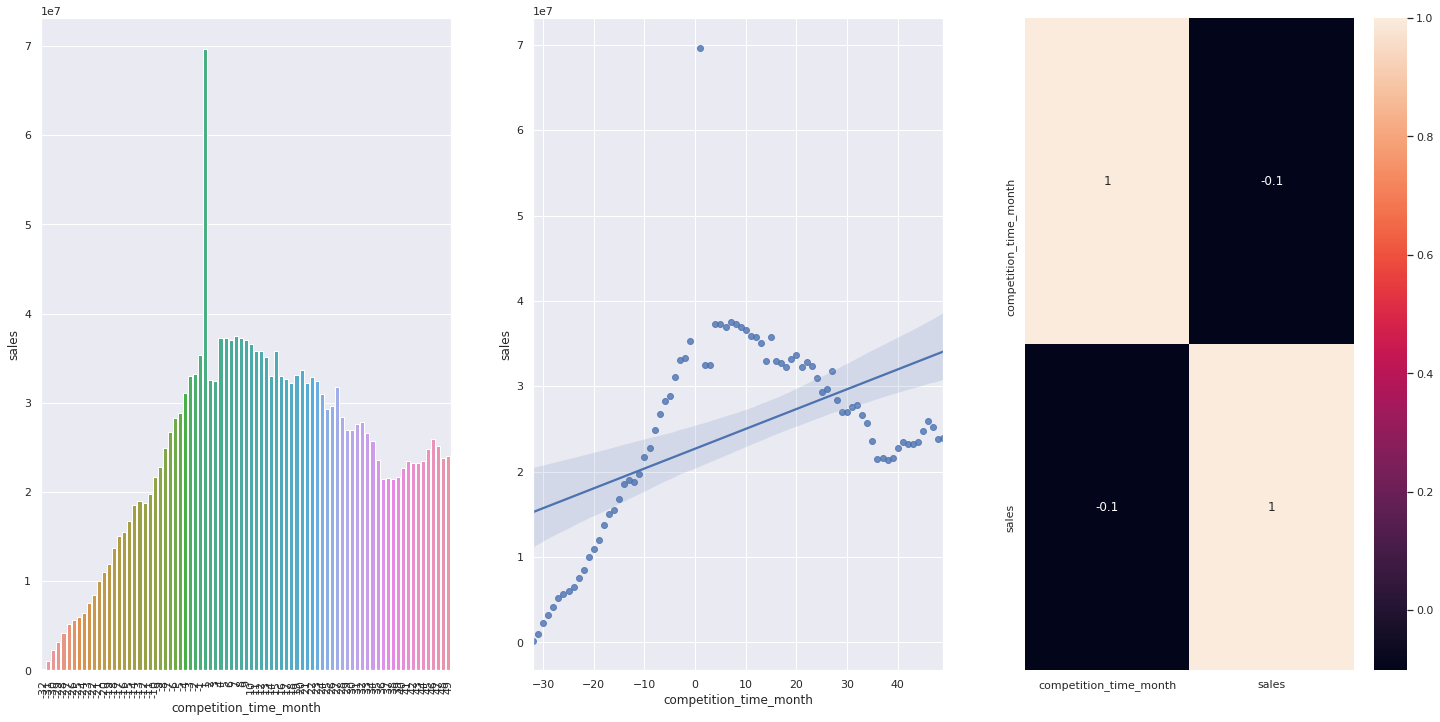

In [ ]:
# subplot(linhas, colunas. posicao)
subplot (1,3,1)
aux6 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# criar filtro de granularidade de competidores que abriram entre 0 e 120 meses
aux7 = aux6[(aux6['competition_time_month'] < 50) & (aux6['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y = 'sales', data = aux7);
# rotate text in barplot 90
plt.xticks( rotation = 90);


subplot (1,3,2)
# correlation ( method = tipode corr, annot = visualizar nr da correlacao)
sns.regplot( x='competition_time_month', y = 'sales', data = aux7);

subplot (1,3,3)
sns.heatmap( aux6.corr(method= 'pearson'), annot = True);

### **H4.** Lojas com promocoes activadas a mais tempo, deveriam vender mais

**Falsa** Porque lojas activas por mais tempo, vendem menos depois de um bom periodo de activacao.

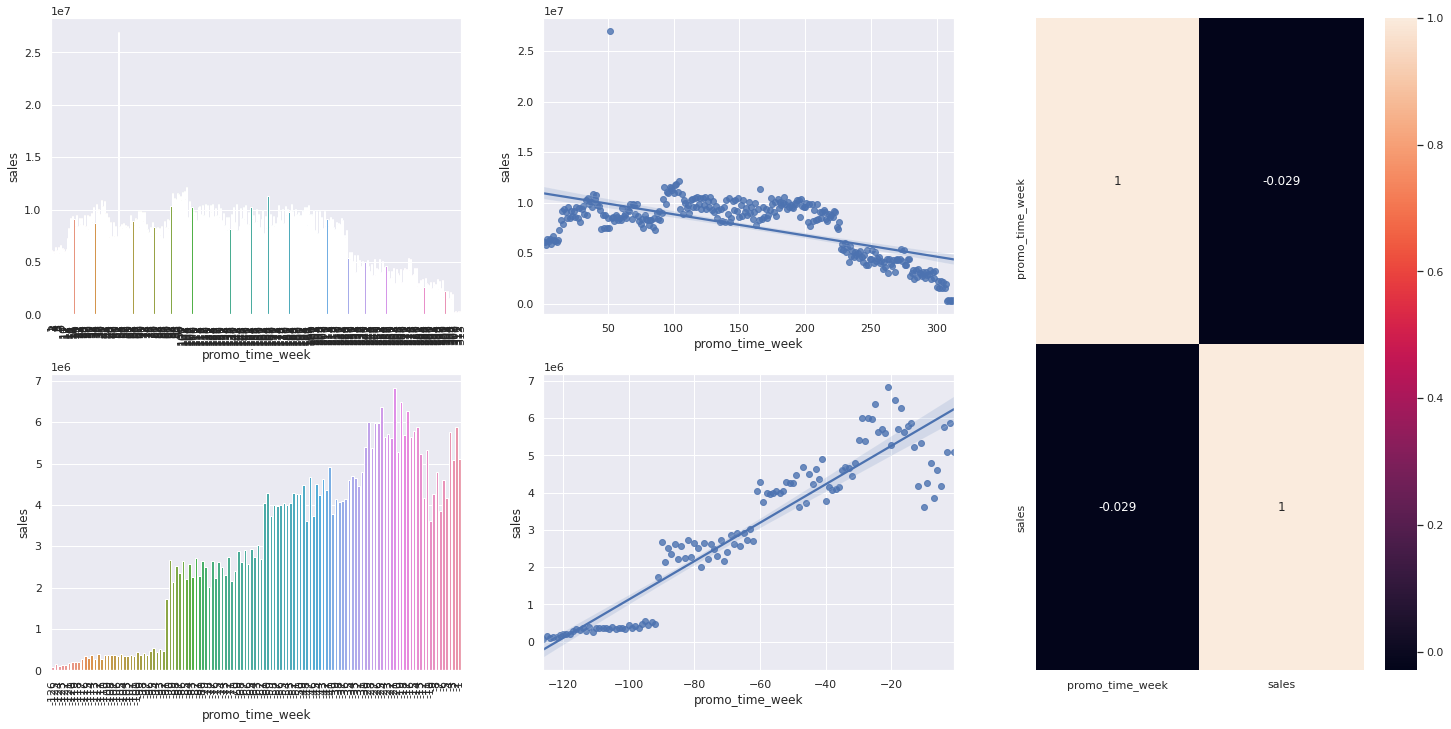

In [ ]:
aux8 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux8);

plt.subplot(grid[0,0])
#linhas e colunas da aux8[]
aux9 = aux8[aux8['promo_time_week'] > 0] # valores positivos periodo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux9);
plt.xticks( rotation = 90);

plt.subplot(grid[0,1])
# tendencia do grafico
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux9);



plt.subplot(grid[1,0])
aux10 = aux8[aux8['promo_time_week'] < 0] # valores  periodo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux10);
plt.xticks( rotation = 90);

plt.subplot(grid[1,1])
# tendencia do grafico
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux10);


plt.subplot(grid[:,2])
sns.heatmap( aux8.corr(method= 'pearson'), annot = True);

###</s>**H5.** Lojas com maid dias de promocao, deveriam vender mais.

### **H6.** Lojas com mais promocoes consecutiva , deveriam vender mais.

**Falsa** Porque lojas com mais promocoes consecutivas vendem menos.

In [ ]:
view = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

In [ ]:
view.head()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


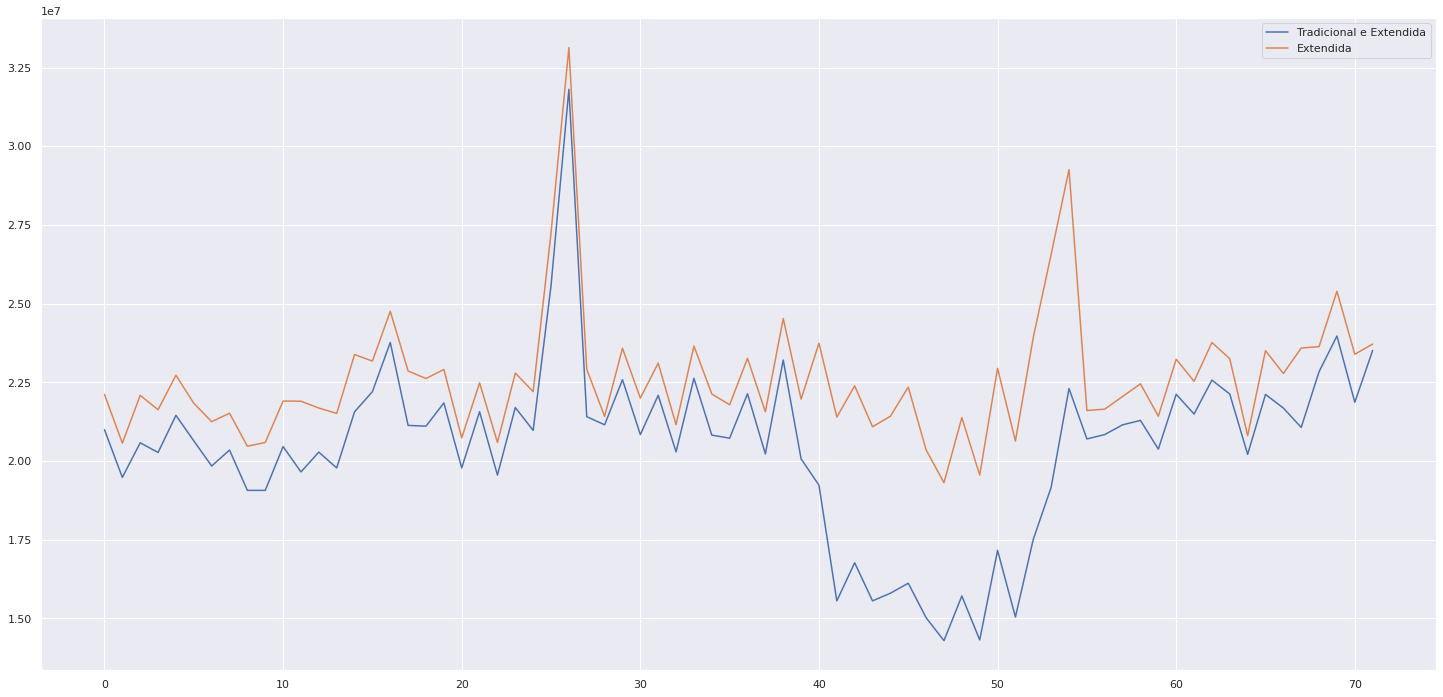

In [ ]:
aux10 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax  = aux10.plot()

aux11 = df4[( df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# plotar os 2 no mesmo grid
aux11.plot( ax = ax)

ax.legend(labels = ['Tradicional e Extendida', 'Extendida']) 

### **H7.** Lojas abertas no feriado de Natal deveriam vender mais.
**Falsa** Porque constatamos que lojas abertas no natal vendem menos em relacao a outro feriado, pascoa no caso.


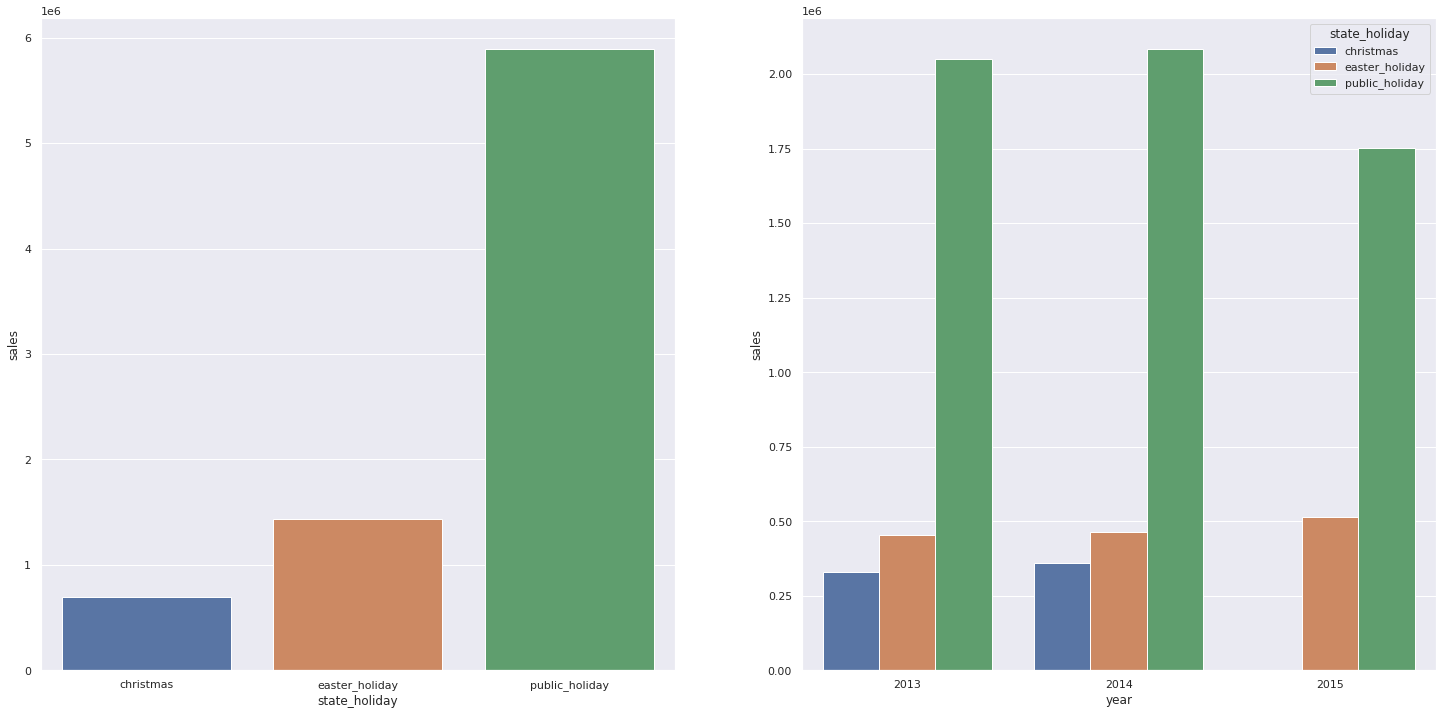

In [ ]:
aux12 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux13 = aux12[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = aux13);

plt.subplot(1,2,2)
# quanto de venda no feriado ao longo do tempo
aux14 = aux12[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday' ]).sum().reset_index()
sns.barplot( x= 'year', y = 'sales', hue = 'state_holiday', data = aux14);

### **H8.** Lojas deveriam vender mais ao longo do tempo (anos).

**Falsa** Lojas estao vendendo cada vez mais ao longo do tempo.

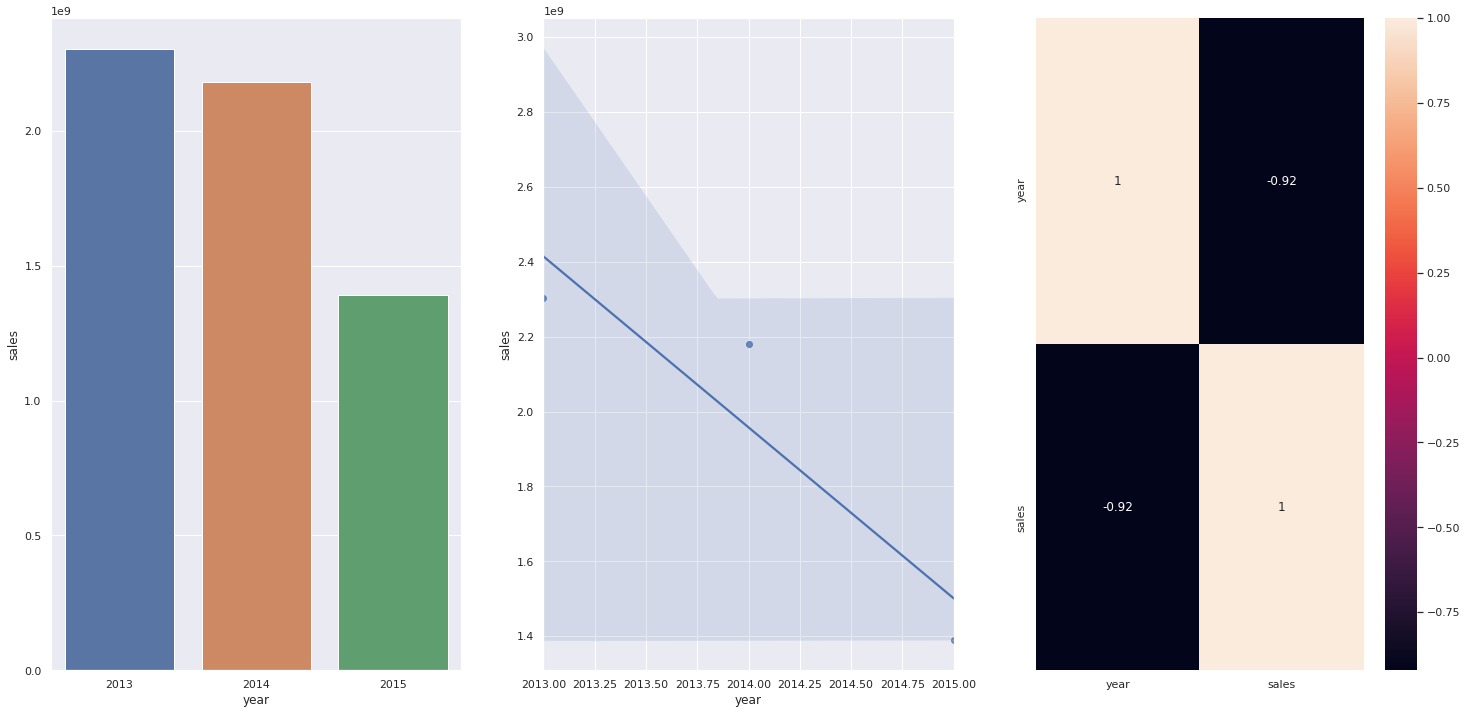

In [ ]:
aux15 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year' , y = 'sales', data = aux15 )
plt.subplot(1,3,2)
sns.regplot(x = 'year' , y = 'sales', data = aux15 );
plt.subplot(1,3,3)

sns.heatmap(aux15.corr( method = 'pearson'),  annot = True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano

**Falsa** Constatamos que lojas estao vendendo mens no segundo semestre  do ano


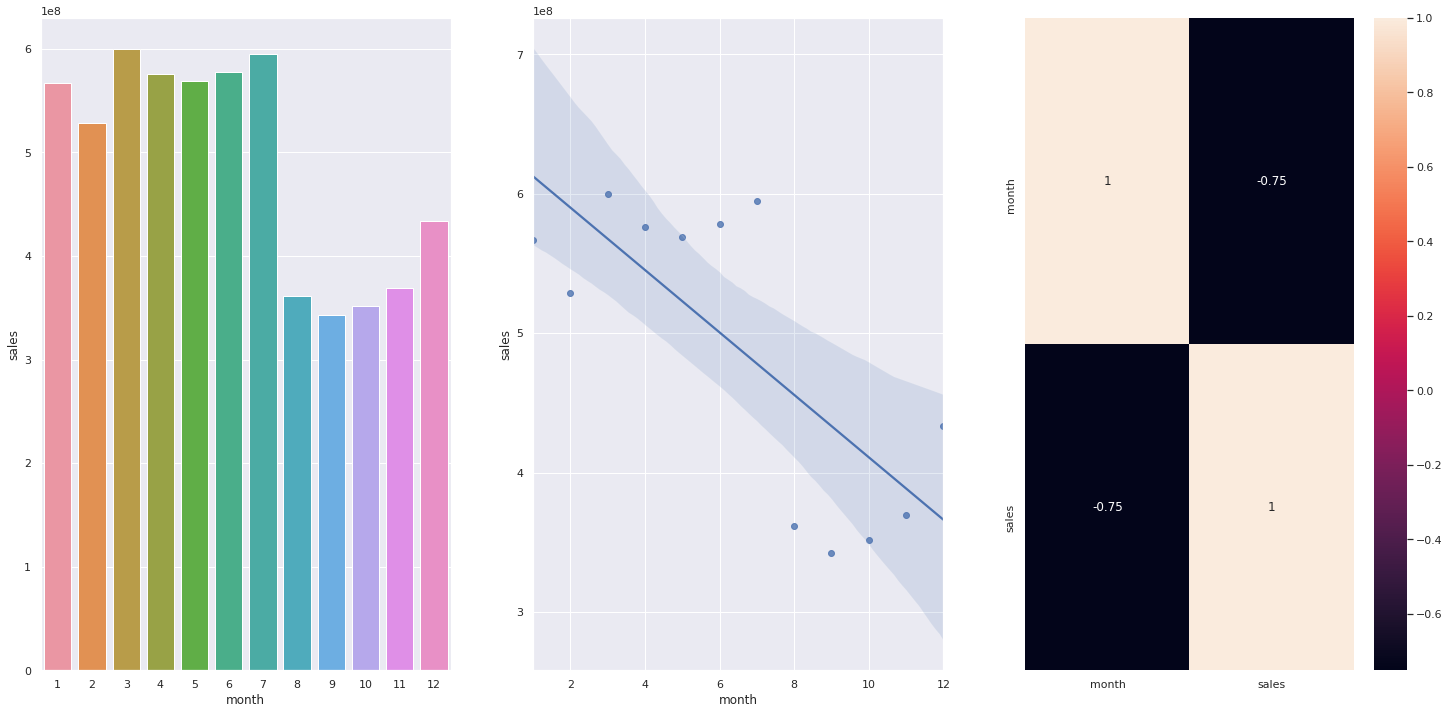

In [ ]:
aux15 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month' , y = 'sales', data = aux15 )
plt.subplot(1,3,2)
sns.regplot(x = 'month' , y = 'sales', data = aux15 );
plt.subplot(1,3,3)

sns.heatmap(aux15.corr( method = 'pearson'),  annot = True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes
**Verdadeira** Constatamos que a hipotese condiz com a realidade



In [ ]:
# aux15['before_after'] = aux15['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
# aux15.head(20)

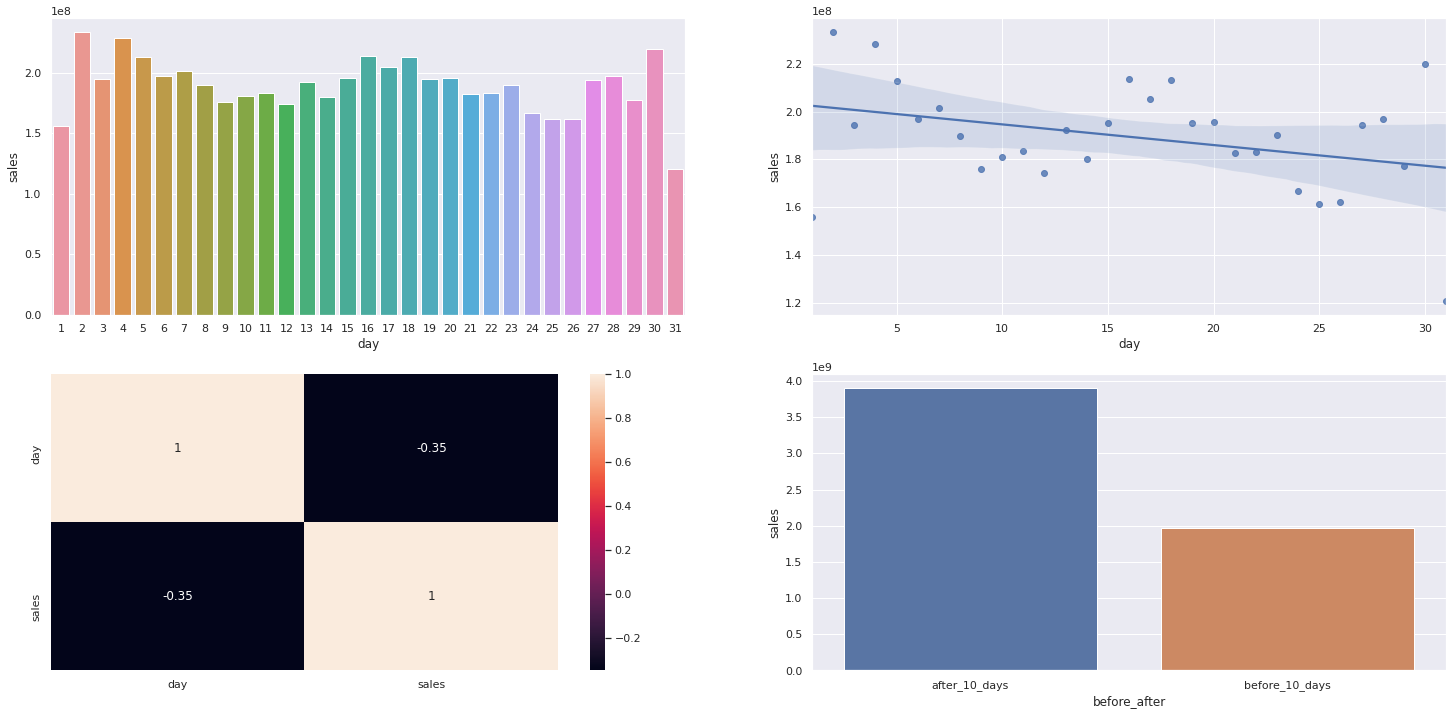

In [ ]:
aux15 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day' , y = 'sales', data = aux15 )
plt.subplot(2,2,2)
sns.regplot(x = 'day' , y = 'sales', data = aux15 );
plt.subplot(2,2,3)
sns.heatmap(aux15.corr( method = 'pearson'),  annot = True )


aux15['before_after'] = aux15['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux16 = aux15[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after' , y = 'sales', data = aux16 );

### **H11.** Lojas deveriam vender menos durante o final de semana

**Verdadeira** Lojas estoa vendendo menos nos finais de semana

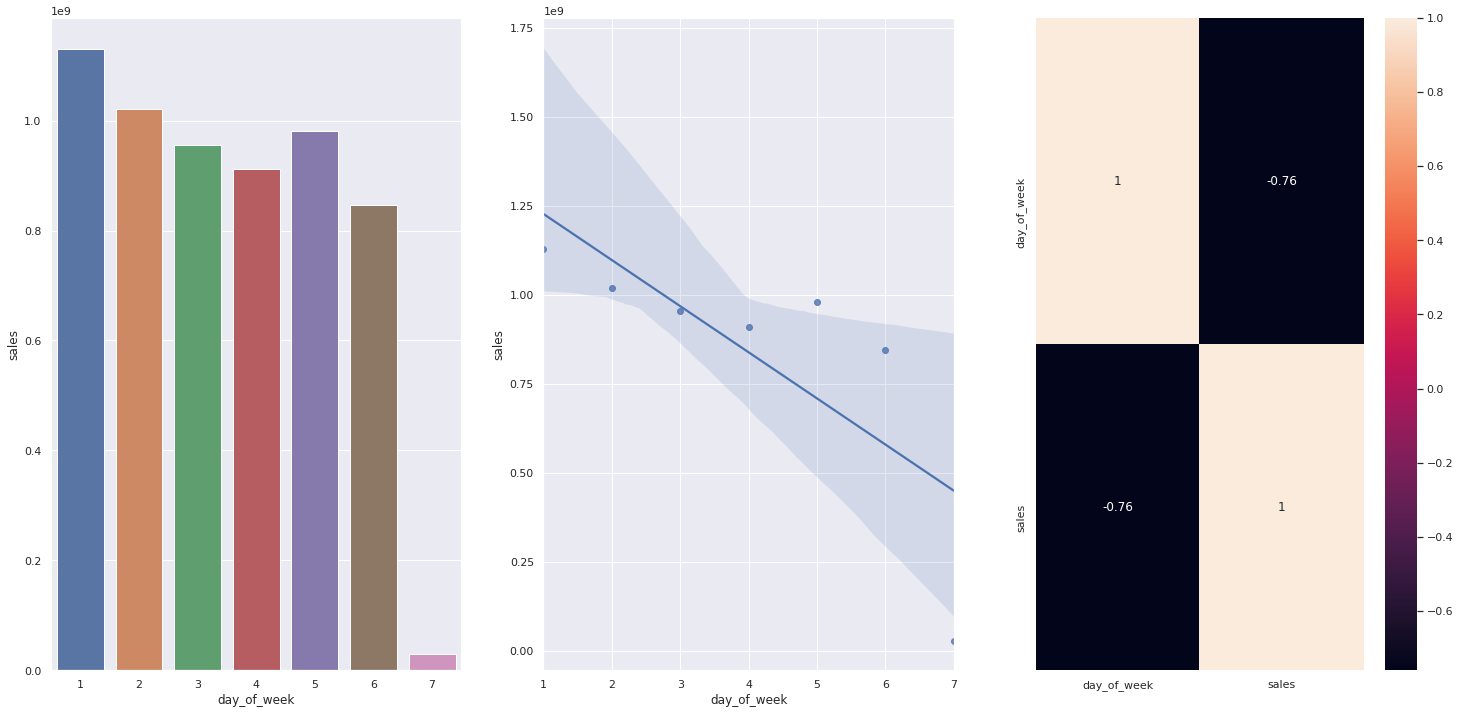

In [ ]:
aux15 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week' , y = 'sales', data = aux15 )
plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week' , y = 'sales', data = aux15 );
plt.subplot(1,3,3)

sns.heatmap(aux15.corr( method = 'pearson'),  annot = True );

### **H12.** Lojas  deveriam vender menos durante os feriados escolares

**Verdadeiro** Lojas teem vendido menos durante o feriado escolar excepto meses de 7 e 8


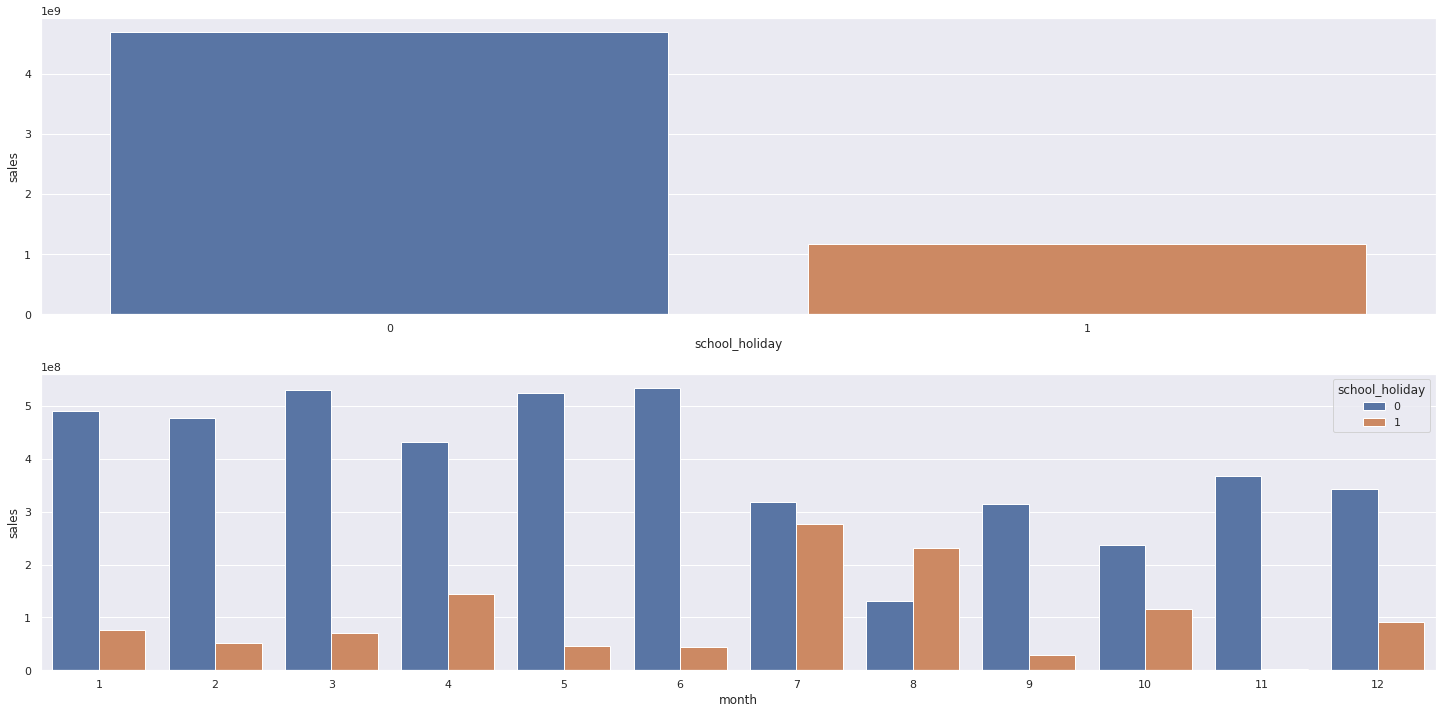

In [ ]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux);


aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue ='school_holiday',  data = aux2);

## 4.3Analise Multivariada

#### 4.3.1 Atributos numericos

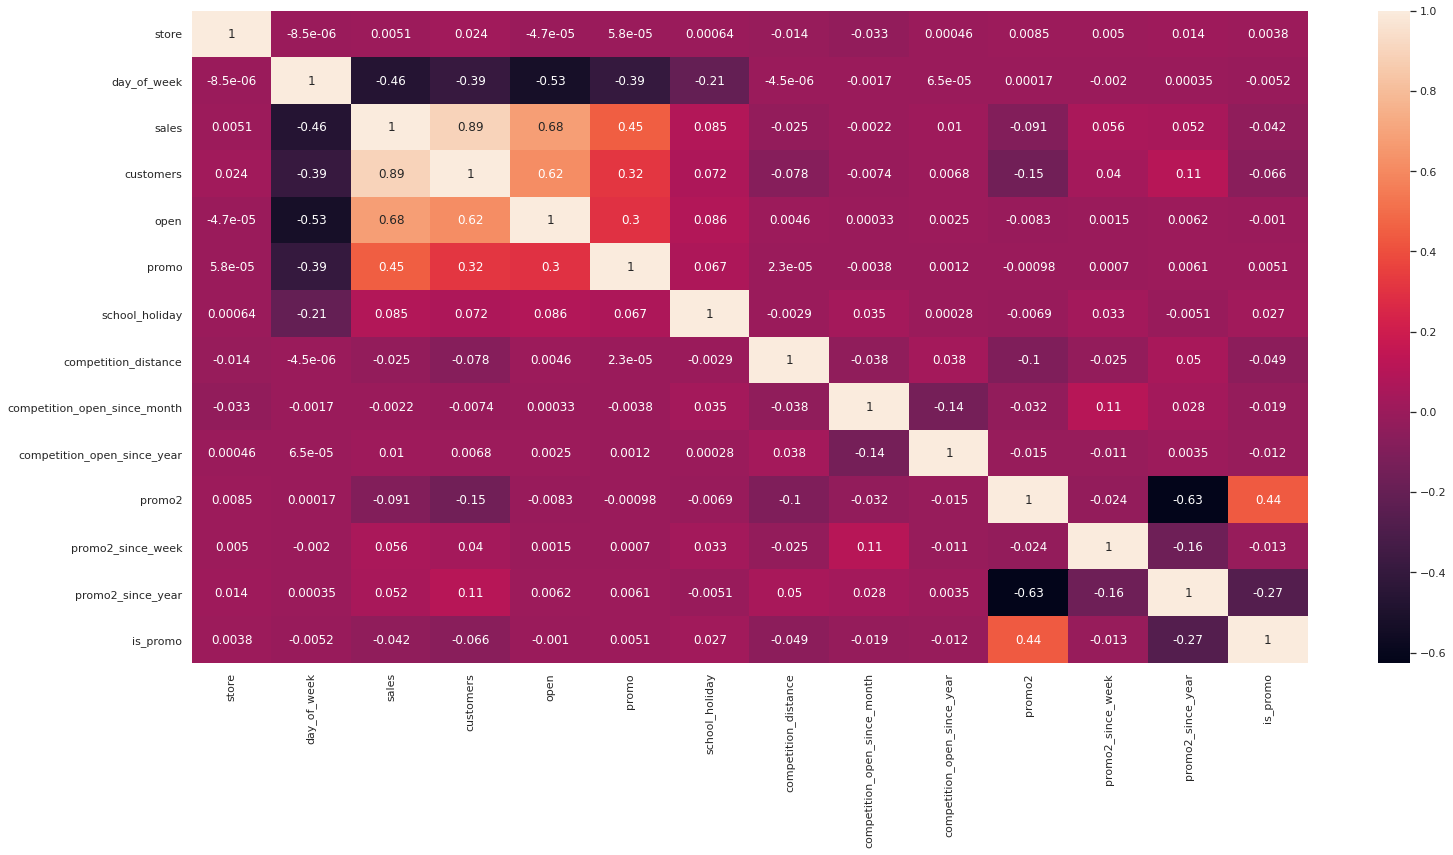

In [ ]:
correlation_num = num_atributes.corr(method  = 'pearson')
sns.heatmap(correlation_num, annot = True );

# perason e um teste estatistico pra calcular 2 vars numericas
# relacao entre pelo menos  uma var categorica usa-se o v-cramer, ou cramer's V

#### 4.3.2 Atributos categoricos

In [ ]:
# actualizando os dados categoricos para o tratamento feito em df4, copiando o tratamento para a var a
a = df4.select_dtypes( include = 'object')
# a.head()

In [ ]:
# criando tabela de correlacao
a1 = crammer_v( a['state_holiday'],a['state_holiday'])
a2 = crammer_v( a['state_holiday'],a['store_type'])
a3 = crammer_v( a['state_holiday'],a['assortment'])

a4 = crammer_v( a['store_type'],a['state_holiday'])
a5 = crammer_v( a['store_type'],a['store_type'])
a6 = crammer_v( a['store_type'],a['assortment'])

a7 = crammer_v( a['assortment'],a['state_holiday'])
a8 = crammer_v( a['assortment'],a['store_type'])
a9 = crammer_v( a['assortment'],a['assortment'])

# Final  dataset
d = pd.DataFrame( { 'state_holiday' : [a1,a2,a3],
               'store_type' : [a4,a5,a6],
               'assortment' : [a7,a8,a9] })

d = d.set_index(d.columns)

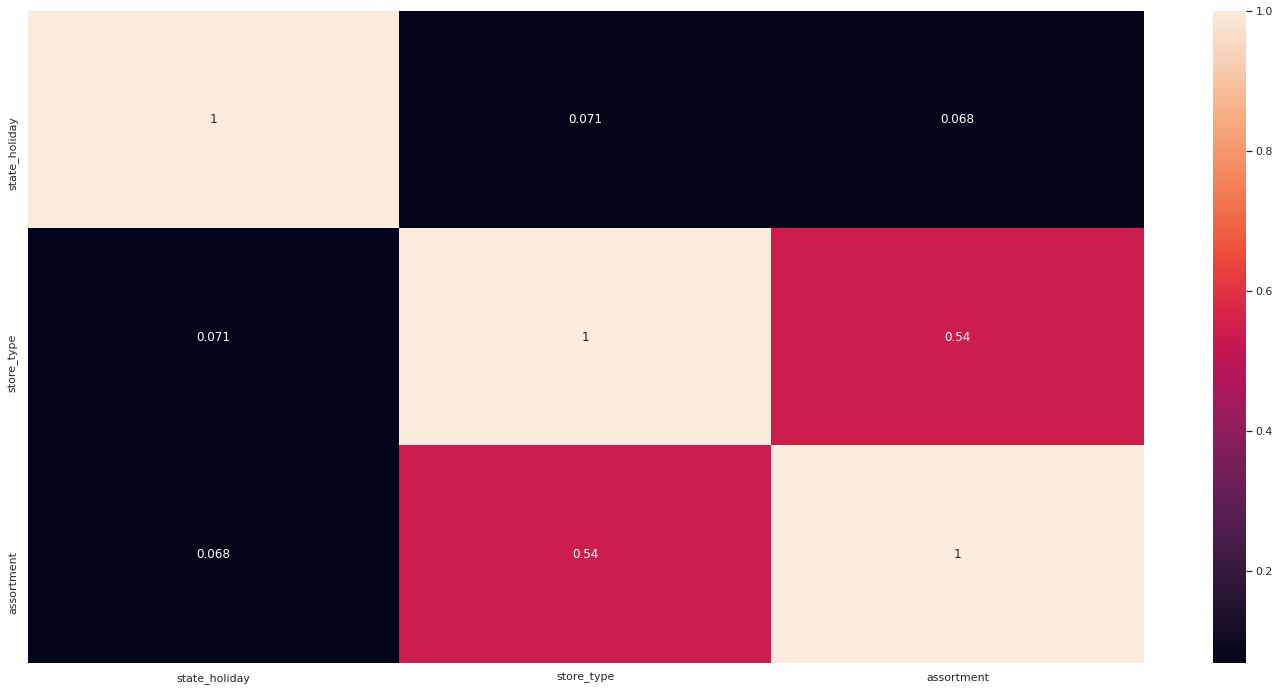

In [ ]:
# heatmap categorical_vars
sns.heatmap(d, annot = True);

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2 Rescaling

In [ ]:
# Selecionar todos dados numericos
a = df5.select_dtypes( include = ['int64', 'float64','int32'])

In [ ]:
# df5.head(1).T

In [ ]:
# # observando os outliers para decidir tecnica de normalizacao a aplicar

# sns.boxplot( df5['promo_time_week'])

In [ ]:
rs = RobustScaler()
nms = MinMaxScaler()

# appply RobustScaler()


# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
# Salvando em pkl
pickle.dump( rs, open( 'competition_distance_scaler.pkl', 'wb' ))



# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
# Salvando em pkl
pickle.dump( rs, open( 'competition_time_month_scaler.pkl', 'wb' ))



# apply MinMaxScaler()
# promo time week
df5['promo_time_week'] = nms.fit_transform( df5[['promo_time_week']].values)
# Salvando em pkl
pickle.dump( rs, open( 'promo_time_week_scaler.pkl', 'wb' ))



# year
df5['year'] = nms.fit_transform( df5[['year']].values)
# Salvando em pkl
pickle.dump( rs, open( 'year_scaler.pkl', 'wb' ))



In [ ]:
# Observando novas distribuicoes
# sns.distplot(df5['year'])

## 5.3 Transformacao

### 5.3.1 Encoding


In [ ]:
#state_holiday
# aplicar one hot encoding,
# prefix =['state_holiday'] - nome que fica enfrente a coluna
# columns coluna que vai realizar o one Hot

df5 = pd.get_dummies( df5, prefix =['state_holiday'], columns= ['state_holiday'])

#assortment 
# Ordinal encoding, mapeando cada valor pela ordem hierarquica

assortment_dict = {'basic' : 1,'extra' : 2,'extended' : 3} 
df5['assortment'] = df5['assortment'].map(assortment_dict )


#store_type - aplicando Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# saving pkl
pickle.dump(le, open('store_type_scaler.pkl', 'wb'))

*Em um segundo ciclo do CRISP podemos tentar outro tipo de encoding, por exemplo o target encoding para todos*

In [ ]:
# # visualizando vars categoricas antes de encodng
# df4.head(4)

# # visualizando vars categoricas depois de encodng
# df5.head(5)

### 5.3.2 Response Var Transformation


In [ ]:
# transformar var responsta usando Logarithm Transformation 

df5['sales'] = np.log1p(df5['sales'])

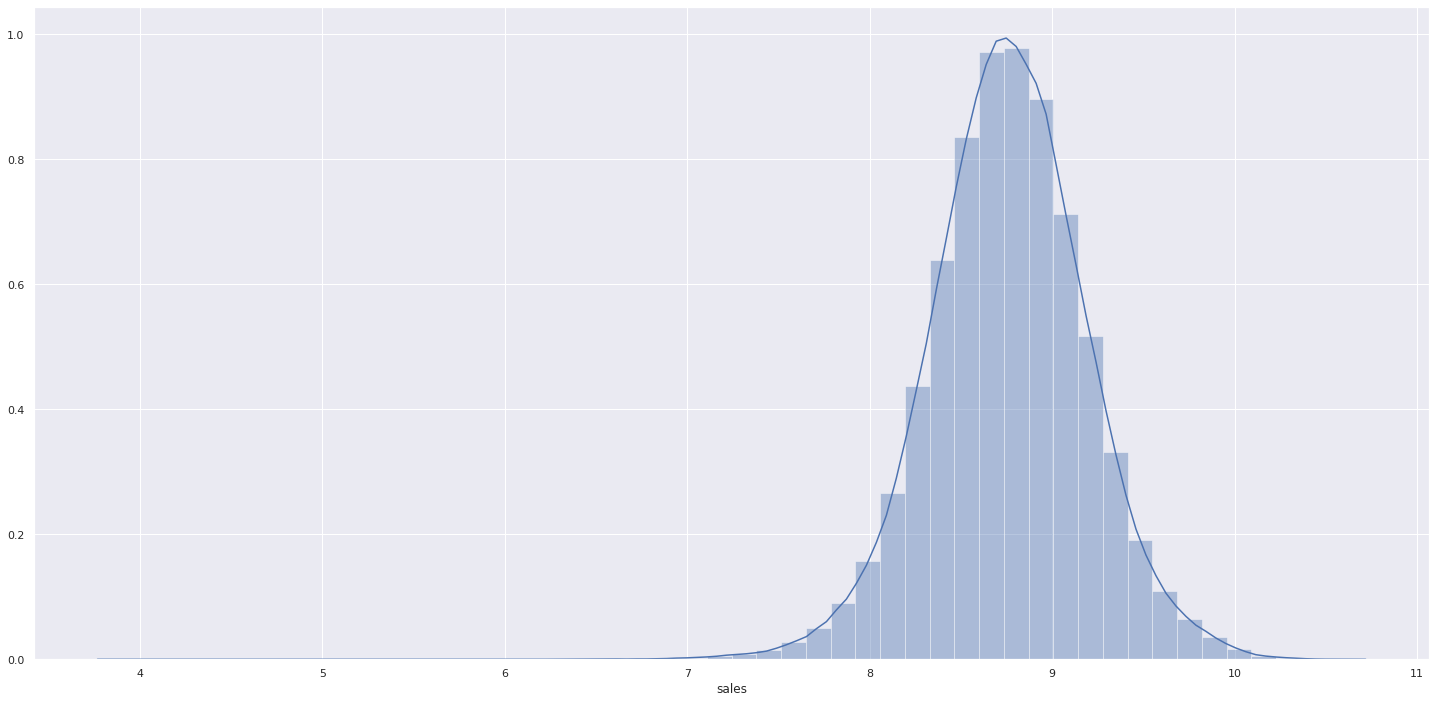

In [ ]:
sns.distplot( df5['sales']);

### 5.3.3 Nature Tranformation


In [ ]:
# month
# 12 nr de meses equivaltente a (1 ciclo)
df5['month_sin'] = df5['month'].apply(lambda x : np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x : np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x : np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x : np.cos( x * ( 2. * np.pi/30 ) ) )
# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos( x * ( 2. * np.pi/52 ) ) )
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_weekr_cos'] = df5['day_of_week'].apply(lambda x : np.cos( x * ( 2. * np.pi/7 ) ) )

In [ ]:
df5.head(2)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_weekr_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Features Selection

In [ ]:
df6 = df5.copy()

## 6.1 Split dataframe into trianing and test dataset

In [ ]:
# df6.head(2).T

In [ ]:
# deletando as variaveis que ja foram derivadas

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition since', 'year_week' ]

In [ ]:
# herdado novas colunas 
df6 = df6.drop( cols_drop, axis =1 )


In [ ]:
#  em uma serie temporal nao podemos selecionar aleatoriamente os dados de train e test, para que o modelo nao pegue 
# aleatoriamente dados futuros e preveja, criando um overfiting

# test - as ultimas  6 semanas para teste

#  primeiras vendas
# df6[['store', 'date']].groupby( 'store').min().reset_index()

# ultimas vendas
#df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0]

## print :  Timestamp('2015-07-31 00:00:00')  - 7 dias = Timestamp('2015-07-24 00:00:00')
# 6 semanas e 6*7 logo:

df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7) #serao os dados de teste

# a primeira data : df6[['store', 'date']].groupby( 'store').min().reset_index(), ate o dia Timestamp('2015-06-19 00:00:00'), que sao 6 semanas
# antes do ultimo dia serao os dados de teste




Timestamp('2015-06-19 00:00:00')

In [ ]:
# training dataset
X_train = df6[ df6 ['date'] < '2015-06-19']
y_train = X_train['sales']

# teste dataset
X_test =  df6[ df6 ['date'] >= '2015-06-19']
y_test = X_test['sales']



print( 'Train MIN date: {}'.format( X_train['date'].min() ) )
print( 'Train MAX date: {}'.format( X_train['date'].max() ) )

print( '\nTest MIN date: {}'.format( X_test['date'].min() ) )
print( 'Ttest MAX date: {}'.format( X_test['date'].max() ) )

Train MIN date: 2013-01-01 00:00:00
Train MAX date: 2015-06-18 00:00:00

Test MIN date: 2015-06-19 00:00:00
Ttest MAX date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector 


In [ ]:
# training and test dataset for boruta
# primeiro precisa de drop date e sales porque n podem constar no modelo logo:






# X_train_n = X_train.drop( ['date', 'sales'], axis = 1).values  # tem que ser um numpy e nao dataframe, logo pear so values
# y_train_n = y_train.values.ravel() # ravel coloca dentro de um vector
# # define Rndom ForestRegressor
# rf = RandomForestRegressor ( n_jobs = -1)
# # define borta

# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n)



### 6.2.1 Best features of Boruta

In [ ]:
# valor do rank
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis = 1)
# cols_selected_boruta  =  X_train_fs.iloc[:, cols_selected].columns.to_list()

# # features not selected Boruta
# # cols_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

# # not selected boruta

# cols_not_selected_boruta = list (np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [ ]:
cols_selected_boruta  = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_weekr_cos']


 # columns to add

feat_to_add = ['date', 'sales']

 # final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [ ]:
cols_not_selected_boruta = ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

# 7.0 Machine Learning Modelling

In [ ]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_weekr_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [ ]:
# legenda
# x_train - todas as variaveis relevantes para o modelo
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Preparation
# x_training - todas as variaveis relevantes  + 'date' + 'sales'
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [ ]:
#Average Model -  Media de vendas de cada loja

aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# predictions

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = { 'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how = 'left', on= 'store')
yhat_baseline = aux1[ 'predictions']


# performance
# aplicar funcao exponencial porque no inicio ponto 6aplicamos a funcao logaritmica 
# e alteramos os dados, pra inverter devemos aplicar a exponencal nos dados com np..expm1
baseline_result= ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performace
lr_result = ml_error( 'Linear regression', np.expm1( y_test ),np.expm1( yhat_lr ) )

# print
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Cross Validation


In [ ]:
lr_result_cv = cross_validation( x_training, 5,'Linear Regression Cross Validation', lr, verbose = False )

lr_result_cv

,Model Name,MAE Cross V,MAPE Cross V,RMSE Cross V
0,Linear Regression Cross Validation,1907.92 +/- 562.5,0.29 +/- 0.04,2741.12 +/- 912.01


## 7.3 Lasso Regression Regularized Model


In [ ]:
# model2
# alpha factor que multiplica os pesos para nao terem valores que sao escessivos
# ajustar o alpha pra menor e.g 0.00001 pode melhorar o modelo, porem leva mais tempo treinando
lrr = Lasso( alpha = 0.001).fit(x_train,y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performace
lrr_result = ml_error( 'Lasso', np.expm1( y_test ),np.expm1( yhat_lrr ) )

# print
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1869.571858,0.288111,2694.005137


## 7.3.1  - Lasso Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5,'Lasso Cross Validation',lrr , verbose = False )
lrr_result_cv

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1194.7812623843347, tolerance: 11.937395279075538
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.47391052043531, tolerance: 12.565835453461386
  positive)


,Model Name,MAE Cross V,MAPE Cross V,RMSE Cross V
0,Lasso Cross Validation,1910.47 +/- 571.26,0.28 +/- 0.04,2766.05 +/- 934.38


In [ ]:
lrr_result_cv

,Model Name,MAE Cross V,MAPE Cross V,RMSE Cross V
0,Lasso Cross Validation,1910.47 +/- 571.26,0.28 +/- 0.04,2766.05 +/- 934.38


## 7.4 Random Forest Regressor

In [ ]:
# # modelo 3
# #random_state e o seed, aleatoriedade
# # n_estimators  - quantas arvores serao craidas (ideal rodar nos 1000, 2000, pois performa melhor, e mehlor rodar em servidor)
# # n_jobs « - roda em paralelo
# rf = RandomForestRegressor( n_estimators = 100, n_jobs= 1, random_state= 25).fit(x_train,y_train)

# # prediction
# yhat_rf = rf.predict( x_test )

# # performace
# rf_result = ml_error( 'Random Forest regressor', np.expm1( y_test ),np.expm1( yhat_rf ) )

# # print
# rf_result

## 7.4.1 Random Forest Regression - Cross Validation

In [ ]:
# rf_result_cv = cross_validation( x_training, 5,'Random Forest Validation',rf , verbose = True )
# rf_result_cv

## 7.5 XGBoost Regressor

In [ ]:
# # modelo 4
# model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
#                               n_estimators = 100, # numero de arvores/ ideal os 2500,3000.
#                               eta = 0.01,
#                               max_depth = 10, # profundidade maxima que a arvore atinge
#                               subsample = 0.7, # percentagem da amostragem das variaveis
#                               colsample_bytee = 0.9 ).fit(x_train,y_train)

# # prediction
# yhat_xgb = model_xgb.predict( x_test )

# # performace
# xgb_result = ml_error( 'XGBoost regressor', np.expm1( y_test ),np.expm1( yhat_xgb ) )

# # print
# xgb_result

## 7.5.1 XGBoost Cross Validation Model

In [ ]:
# xgb_result_cv = cross_validation( x_training, 5,'XGBoost Cross Validation',model_xgb , verbose = True )
# xgb_result_cv

## 7.6 Compare Models Performace (Before Cross Validation)

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

first_performace_compare = modelling_result.sort_values('RMSE')

## 7.7 Compare Models Performace (After Cross Validation) # Real Performace

In [ ]:
modelling_result = pd.concat([rf_result_cv, lrr_result_cv, lr_result_cv, xgb_result_cv])
corss_validation_compare = modelling_result.sort_values('RMSE Cross V')
corss_validation_compare

In [ ]:
# assinatura do metodo
# def cross_validation( x_training, kfold, model_name, model, verbose = False)



# 8.0 Hiperparameter Fine Tuning

## 8.1 Random search

In [ ]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [ ]:
param = {
    'n_estimators' : [3000,3500],
    'eta' : [0.01, 0.03],
    'max_depth' : [3, 5, 9],
    'subsample' : [0.1, 0.5, 0.7],
    'colsample_bytee' : [0.3, 0.7, 0.9],
    'min_child_weigth' : [3, 8, 15]
    }

MAX_EVAL = 2

In [ ]:
# # # Hiperparameter with XGBoost
# # final_result = pd.DataFrame()
# # # escolha aleatoria

# for i in range (MAX_EVAL):
#   # chosse values for parameters randomly
#   hp = { k: random.sample (v, 1)[0] for k, v in param.items()}
#   print ( hp )

#   model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta =  hp['eta'],
#                                 max_depth =  hp['max_depth'], 
#                                 subsample =  hp['subsample'], 
#                                 colsample_bytee = hp['colsample_bytee'],
#                                 min_child_weigth =hp['min_child_weigth'] )


#   # performace
#   result = cross_validation( x_training, 2, 'XGBoost regressor', model_xgb, verbose = False)
#   result = pd.concat( [final_result, result])

#   # print
# final_result

## 8.2 Final Model

In [ ]:
param_tuned = {
    'n_estimators' :2500 ,
    'eta': 0.01 ,
    'max_depth':5 ,
    'subsample': 0.7 ,
    'colsample_bytree' :0.9 ,
    'min_child_weigth' : 3
    }


In [ ]:
# Hiperparameter final 

model_xgb_tuned = xgb.XGBRegressor( objective= 'reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta =  param_tuned['eta'],
                                    max_depth =  param_tuned['max_depth'], 
                                    subsample =  param_tuned['subsample'], 
                                    colsample_bytee = param_tuned['colsample_bytree'],
                                    min_child_weigth =param_tuned['min_child_weigth'] ).fit( x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performace
xgb_result_tuned = ml_error( 'XGBoost regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

  # print
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost regressor,685.088664,0.099943,982.641665


In [ ]:
dic_xgb_fina_result =  { 'MAE  :' : 685.088664,
                         'MAPE :' : 0.099943,
                         'RMSE :' : 982.641665
                      }

dic_xgb_fina_result

{'MAE  :': 685.088664, 'MAPE :': 0.099943, 'RMSE :': 982.641665}

## Salvando o modelo xgb_tuned

In [ ]:
pickle.dump( model_xgb_tuned, open('rossmann.pkl', 'wb'))

## interpretando o MAE,MAPE,RMSE

### O MAE representa o valor medio ddo erro absoluto. portanto dependendo da unidade da variavel resposta, o valor do MAE pode ser interpretado como bom ou mau.

### O MAPE representa a porcentagem do MAE, quantos por cento representa o valor do MAE no meu erro. No caso do nosso modelo, temos uma percentagem de quase 10%

In [ ]:
#np.expm1 so porque os valore sde y_test estao na escala de log, usamos np.expm1 para trazer a escala original
np.expm1( y_test).min()


569.0000000000002

In [ ]:
np.expm1( y_test).max()



41550.99999999998

In [ ]:
np.expm1(y_test).max() - np.expm1(y_test).min()


40981.99999999998

In [ ]:
# media da varavel resposta 
np.expm1(y_test).mean()

6995.162576094309

##  temos 41550 Meticais em **range** de variavel resposta, com um erro de 685 Meticais(MAE). O **MAPE** representa a porcentagem do MAE. neste caso temos um **MAPE** de 10%. Quer dizer que em um valor real de 100, o modelo tentando prever, pode  errar 10%, superestimando (prever 110) ou subestimando (prever 90) 

In [ ]:
# y_test mean divididoo pelo MAE
#MAE/y-mean
685/6995

# 10% - errro, que e igual ao MAE, ou seja o MAPE

0.09792709077912795

In [ ]:
# y_test mean divididoo pelo RMSE

#RMSE/y-mean
982/6995

# 14% - erro, que e a porcentagem do RMSE, ou seja o RMSPE

0.14038598999285204

In [ ]:
# calculando o MPE

mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.002274003953573475

### valor  negativo ( - ) significa superstimacao de valores, e valores  positivos ( + ) subestimacao de valores.

# 9.0 Traducao e interpretacao do erro

In [ ]:
df9 = X_test[ cols_selected_boruta_full]

# rescaling
df9['sales'] = np.expm1( df9['sales'] ) 
df9['predictions'] = np.expm1( yhat_xgb_tuned ) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 9.1 Business Performace

In [ ]:
# sum of prediction for store
# lembrando que estamos prevendo predicao de vendas por lojas
# para saber a posicao do CEO para investimentos.

df91 = df9[[ 'store', 'predictions']].groupby( 'store' ).sum().reset_index()



# MAE e MAPE para cada loja


df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x[ 'predictions']) ).reset_index().rename( columns = {0 : 'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x[ 'predictions']) ).reset_index().rename( columns = {0 : 'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge( df91, df9_aux3, how = 'inner', on = 'store')



# Scenarios
# Criando cenarios bons e maos, com MAE susperestimado, e subestimado


df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']



# ordenando columnas

df92 = df92 [['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


df92.tail()



,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1110,1111,181242.218750,180600.164518,181884.272982,642.054232,0.137588
1111,1112,330048.781250,329074.103133,331023.459367,974.678117,0.117065
1112,1113,241005.015625,240464.560125,241545.471125,540.455500,0.083715
1113,1114,763917.250000,761503.913007,766330.586993,2413.336993,0.104664
1114,1115,264040.687500,263302.851219,264778.523781,737.836281,0.104725


In [ ]:
df92.sort_values( 'MAPE', ascending= False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103566.492188,100276.526444,106856.457931,3289.965743,0.550947
908,909,233369.515625,225534.470257,241204.560993,7835.045368,0.527501
875,876,201461.375000,197513.207159,205409.542841,3948.167841,0.304906
721,722,349262.718750,347371.726259,351153.711241,1890.992491,0.252295
273,274,194290.359375,192904.014262,195676.704488,1386.345113,0.242423
781,782,220323.734375,219562.706912,221084.761838,761.027463,0.229423
270,271,277615.562500,276437.608728,278793.516272,1177.953772,0.212739
1013,1014,414126.437500,412565.346205,415687.528795,1561.091295,0.205515
533,534,281394.812500,280090.726312,282698.898688,1304.086188,0.204168
674,675,146107.734375,145441.523193,146773.945557,666.211182,0.203375


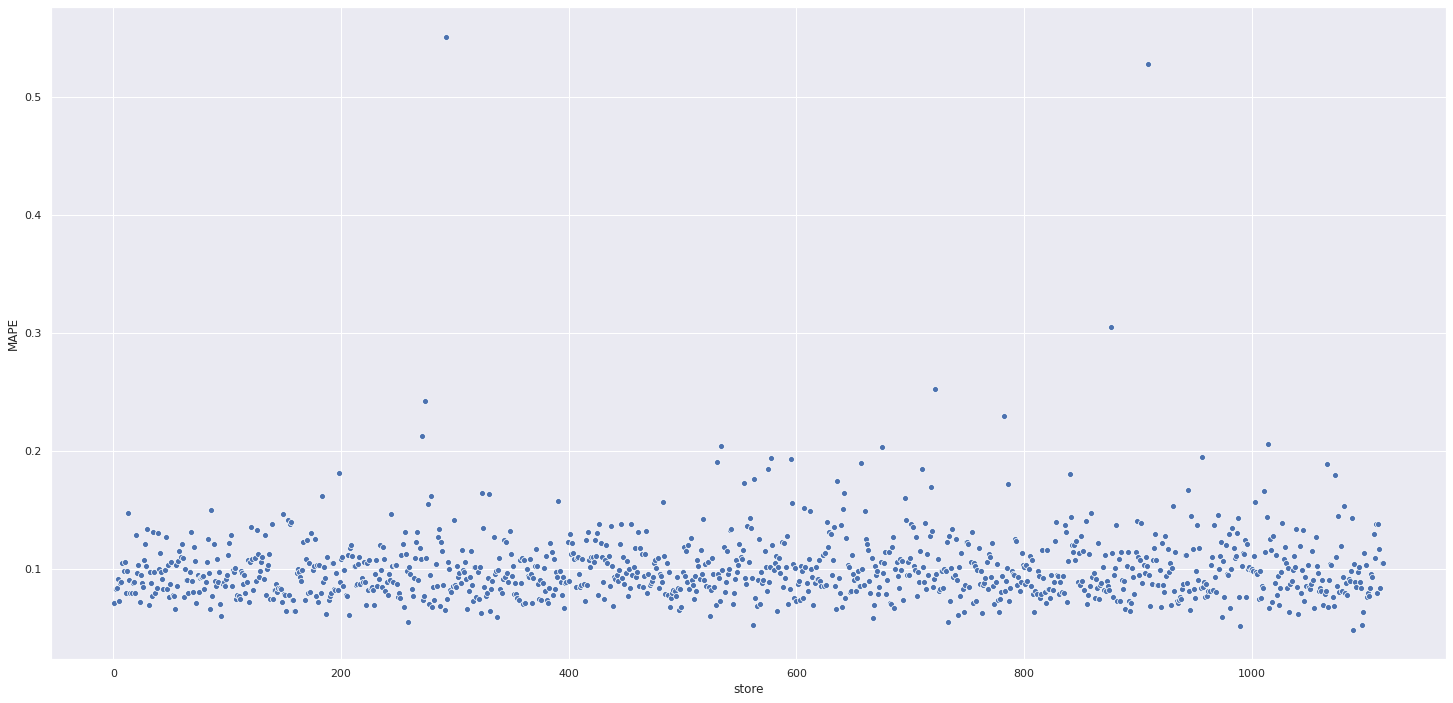

In [ ]:
sns.scatterplot( x = 'store', y = 'MAPE', data =  df92)

## 9.2 Total Performace

In [ ]:

# Total de todas vendas por lojas:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93[ 'Values'] = df93['Values'].map( 'USD {:,.2f} '.format)

df93


,Scenario,Values
0,predictions,"USD 284,246,549.15"
1,worst_scenario,"USD 283,478,817.74"
2,best_scenario,"USD 285,014,280.56"


## 9.3 ML Performace

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']

df9['error_rate'] = df9['predictions'] / df9['sales']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


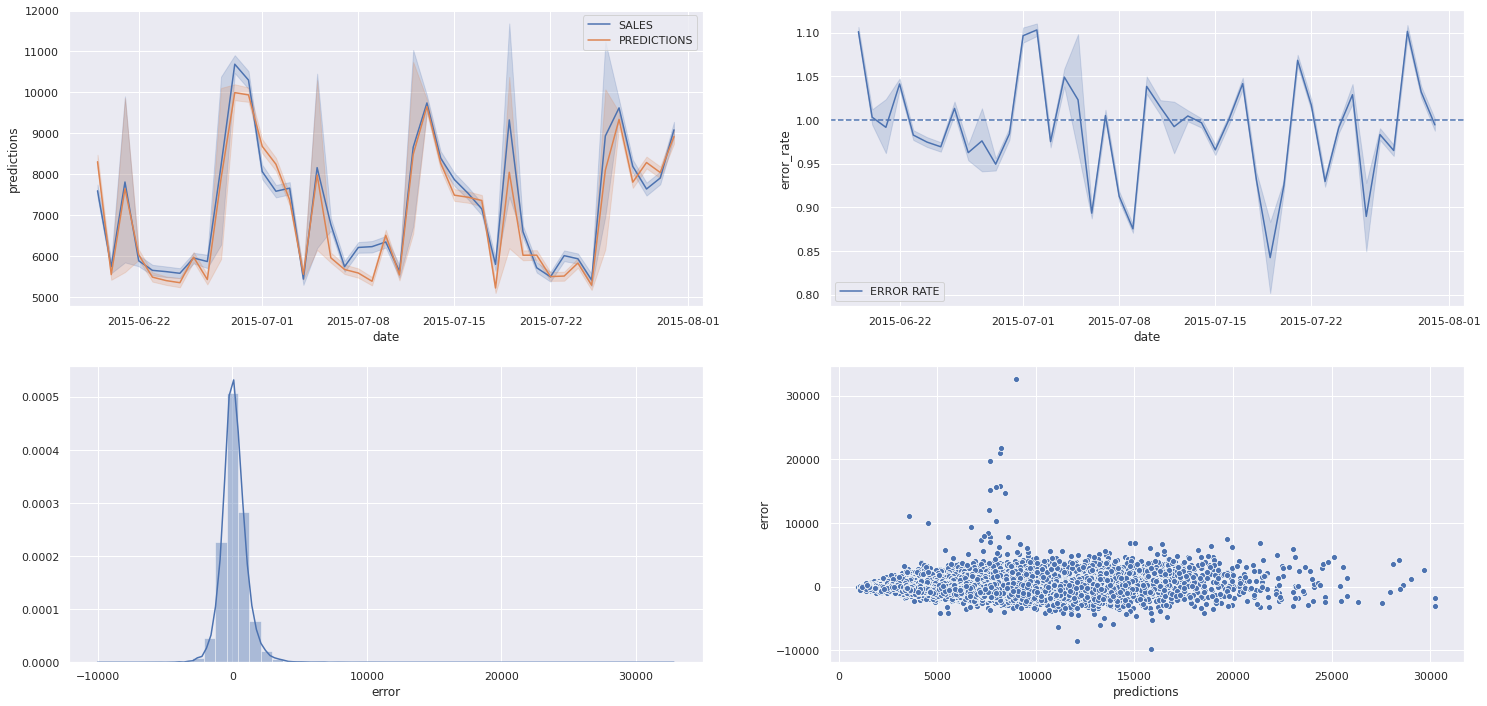

In [ ]:
plt.subplot( 2,2,1)


sns.lineplot ( x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot ( x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')


plt.subplot( 2,2,2)
sns.lineplot ( x = 'date', y = 'error_rate', data = df9, label = 'ERROR RATE')
plt.axhline( 1, linestyle='--')
# Se a avaliacao for acima do -- , temos uma superstimacao, do contrario subestimacao



plt.subplot( 2,2,3)
sns.distplot ( df9[ 'error'])
# Distribuicao do erro  -  analise do residuo

plt.subplot( 2,2,4)
sns.scatterplot ( df9[ 'predictions'], df9[ 'error'] );
# predicao/erro -  analise do residuo, apresenta pontos fracos, e o que deve-se fazer para melhorar o residuo.
# quanto maior o valor de previsoes maior o erro.
# o ideal e que as amostras facam uma representacao de um cubo horizontal, com menos numeros de outliers possivel.


# 10.0 Deploy Model


## 10.1 Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
  def __init__( self ):
    self.home_path='C:\Users\AL\Desktop\data-science-producao\ '

    self.competition_distance_scaler   = pickle.load( open(  self.home_path + 'data_preparations\competition_distance_scaler.pkl', 'rb' ))
    self.competition_time_month_scaler = pickle.load( open(  self.home_path + 'data_preparations\competition_time_month_scaler.pkl', 'rb' ))
    self.promo_time_week_scaler        = pickle.load( open(  self.home_path + 'data_preparations\promo_time_week_scaler.pkl', 'rb' ))
    self.year_scaler                   = pickle.load( open(  self.home_path + 'data_preparations\year_scaler.pkl', 'rb' ))
    self.store_type_scaler             = pickle.load( open(  self.home_path + 'data_preparations\store_type_scaler.pkl', 'rb' ))

  
      
  def data_cleaning( self, df1 ):



    # rename columns with snakecase
    cols_old = ['Store','DayOfWeek','Date','Open', 'Promo','StateHoliday', 'SchoolHoliday','StoreType','Assortment','CompetitionDistance',
                'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']



    snakecase = lambda x: inflection.underscore(x)

    cols_new = list(map(snakecase, cols_old))

    # rename columns
    df1.columns = cols_new


    ## 1.3. Data Types
    df1['date'] = pd.to_datetime( df1['date'] )

    ## 1.5. Fillout NA
    #competition_distance        
    df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x) 


    #competition_open_since_month
    df1['competition_open_since_month'] = df1.apply( lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)


    #competition_open_since_year 
    df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)


    #promo2_since_week           
    df1['promo2_since_week'] = df1.apply( lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

    

    #promo2_since_year           
    df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)


    #promo_interval              
    month_map  = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sept",  10: "Oct",  11: "Nov",  12: "Dec"}

    # Fill NA = 0.
    df1['promo_interval'].fillna(0, inplace = True)

    df1['month_map'] = df1['date'].dt.month.map(month_map)

    df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


    ## 1.6. Change Data Types
    # competiton

    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )    


    # promo2

    df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
    df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

    return df1 


  def feature_engineering( self, df2 ):
    # year
    df2['year'] = df2['date'].dt.year

    # month
    df2['month'] = df2['date'].dt.month

    # day
    df2['day'] = df2['date'].dt.day

    # week of year
    df2['week_of_year'] = df2['date'].dt.weekofyear


    # year week
    # mudar a formatacao da data apenas
    df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


    # competition since

    df2['competition since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day= 1), axis = 1)
    df2['competition_time_month'] = (( df2['date'] - df2['competition since'])/30).apply( lambda x: x.days).astype(int)



    # promo since
    df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +df2['promo2_since_week'].astype( str )
    df2['promo_since'] = df2['promo_since'].apply(lambda x :datetime.datetime.strptime( x  + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7))
    df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

    # assortment
    df2['assortment'] = df2['assortment'].apply(lambda x:"basic" if x =="a" else "extra" if x == "b" else  "extended")

    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x== 'c' else 'regular_day')



    # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
    ## 3.1. Filtragem das Linhas
    df2 = df2[df2['open'] != 0]

    ## 3.2. Selecao das Colunas
    drop_cols = [ "open","promo_interval","month_map"]

    # axis = 0 - linhas, =1 colunas 
    df2 = df2.drop(drop_cols, axis = 1)

    return df2





  def data_preparation( self, df5 ):

    df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)
    # competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)

    # apply MinMaxScaler()
    # promo time week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
    # year
    df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)




    ### 5.3.1. Encoding


    f5 = pd.get_dummies( df5, prefix =['state_holiday'], columns= ['state_holiday'])

    #assortment 
    # Ordinal encoding, mapeando cada valor pela ordem hierarquica

    # assortment_dict = {'basic' : 1,'extra' : 2,'extended' : 3} 
    # df5['assortment'] = df5['assortment'].map(assortment_dict )


    #store_type - aplicando Label encoding
    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])



    # assortment - Ordinal Encoding
    assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
    df5['assortment'] = df5['assortment'].map( assortment_dict )

    
    ### 5.3.3. Nature Transformation
    # day of week
    df5['month_sin'] = df5['month'].apply(lambda x : np.sin( x * ( 2. * np.pi/12 ) ) )
    df5['month_cos'] = df5['month'].apply(lambda x : np.cos( x * ( 2. * np.pi/12 ) ) )

    # day
    df5['day_sin'] = df5['day'].apply(lambda x : np.sin( x * ( 2. * np.pi/30 ) ) )
    df5['day_cos'] = df5['day'].apply(lambda x : np.cos( x * ( 2. * np.pi/30 ) ) )

    # week_of_year
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin( x * ( 2. * np.pi/52 ) ) )
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos( x * ( 2. * np.pi/52 ) ) )

    # day_of_week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin( x * ( 2. * np.pi/7 ) ) )
    df5['day_of_weekr_cos'] = df5['day_of_week'].apply(lambda x : np.cos( x * ( 2. * np.pi/7 ) ) )
            
    # Select boruta variables
    cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                      'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                      'promo_time_week','month_cos','month_sin','day_sin','day_cos','week_of_year_cos','week_of_year_sin','day_of_week_sin','day_of_weekr_cos']


    return df5[ cols_selected ]
    
    
  def get_prediction( self, model, original_data, test_data ):
      # prediction
      pred = model.predict( test_data )
      
      # join pred into the original data
      original_data['prediction'] = np.expm1( pred )
      
      return original_data.to_json( orient='records', date_format='iso' )



## 10.2 API

In [ ]:
import pandas          as pd
import pickle
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model

model = pickle.load(open('rossmann.pkl', 'rb'))

app = Flask(__name__)

@app.rout( '/rossmann/predict', methods = ['POST'])


# init API
def rossmann_predict():
  test_json = request.get_json

  if test_json: # there is data
    if isinstance( test_json, dict): # unique examples
      test_raw = pd.DataFrame(   test_json , index=[0] )
      
    else: # multiple examples
      test_raw = pd.DataFrame(   test_json , columns = test_json[0].key() )

      # instance Rossmann class

      pipeline = Rossmann()

      # data cleaning

      df1 = pipeline.data_cleaning( test_raw)
      # features engineering
      df2 = pipeline.feature_engineering( df1 )
      # data preparation
      df3 = pipeline.data_preparation( df2 )

      # prediction

      df_response = pipeline.get_prediction( model, test_raw, df3 )

      return df_response


  else:

    return Response( '{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
  app.run( '0.0.0.0' )

ModuleNotFoundError: ignored

## 10.3 API Test

In [ ]:
import json
import requests

In [ ]:
df10 = pd.read_csv('test.csv')

In [ ]:
# loading test data

df10.head()

In [ ]:
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# select rows

df_test = df_test[df_test['Store'] == 10 ]

# remove store closed
df_test = df_test[df_test['Open'] != 0]

# not nul
df_test = df_test[-df_test['Open'].isnull()]

# drop ID no eixo 1
df_test = df_test.drop( 'Id', axis = 1)


In [ ]:
# convert dataframe to JSon

data = json.dumps( df_test.to_dict( orient = 'records' ) )
data

'[{"Store": 10, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 3160.0, "CompetitionOpenSinceMonth": 9.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 10, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 3160.0, "CompetitionOpenSinceMonth": 9.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 10, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 3160.0, "CompetitionOpenSinceMonth": 9.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "

In [ ]:
# API Call

url = 'http://0.0.0.0:5000/rossman/predict'
header = { 'Content-type' : 'application/json'}
data = data

r = request.post( url, data, headers = header)
print( 'Status Code {}'.format( r.status_code))


